In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



# Load Data and Assign Column Names


In [25]:
# %%
# Load the train and test datasets (assuming they are CSV-like TXT files)
train_data = pd.read_csv("KDDTrain+.txt", sep=",", encoding='utf-8', header=None)
test_data  = pd.read_csv("KDDTest+.txt", sep=",", encoding='utf-8', header=None)

# Define column names (43 columns: 41 features + 'attack' + 'difficulty')
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", 
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", 
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "attack", "difficulty"
]

train_data.columns = columns
test_data.columns = columns


# Explore and Visualize the Combined Dataset

In [26]:
# Combine train and test data
combined_df = pd.concat([train_data, test_data], ignore_index=True)
print("Combined DataFrame shape:", combined_df.shape)

# Clean string columns (remove extra spaces)
for col in ['protocol_type', 'service', 'flag', 'attack']:
    combined_df[col] = combined_df[col].astype(str).str.strip()

# Check basic info
print(combined_df.info())
print("Duplicates:", combined_df.duplicated().sum())

# Drop duplicate rows
combined_df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", combined_df.shape)

Combined DataFrame shape: (148517, 43)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised    

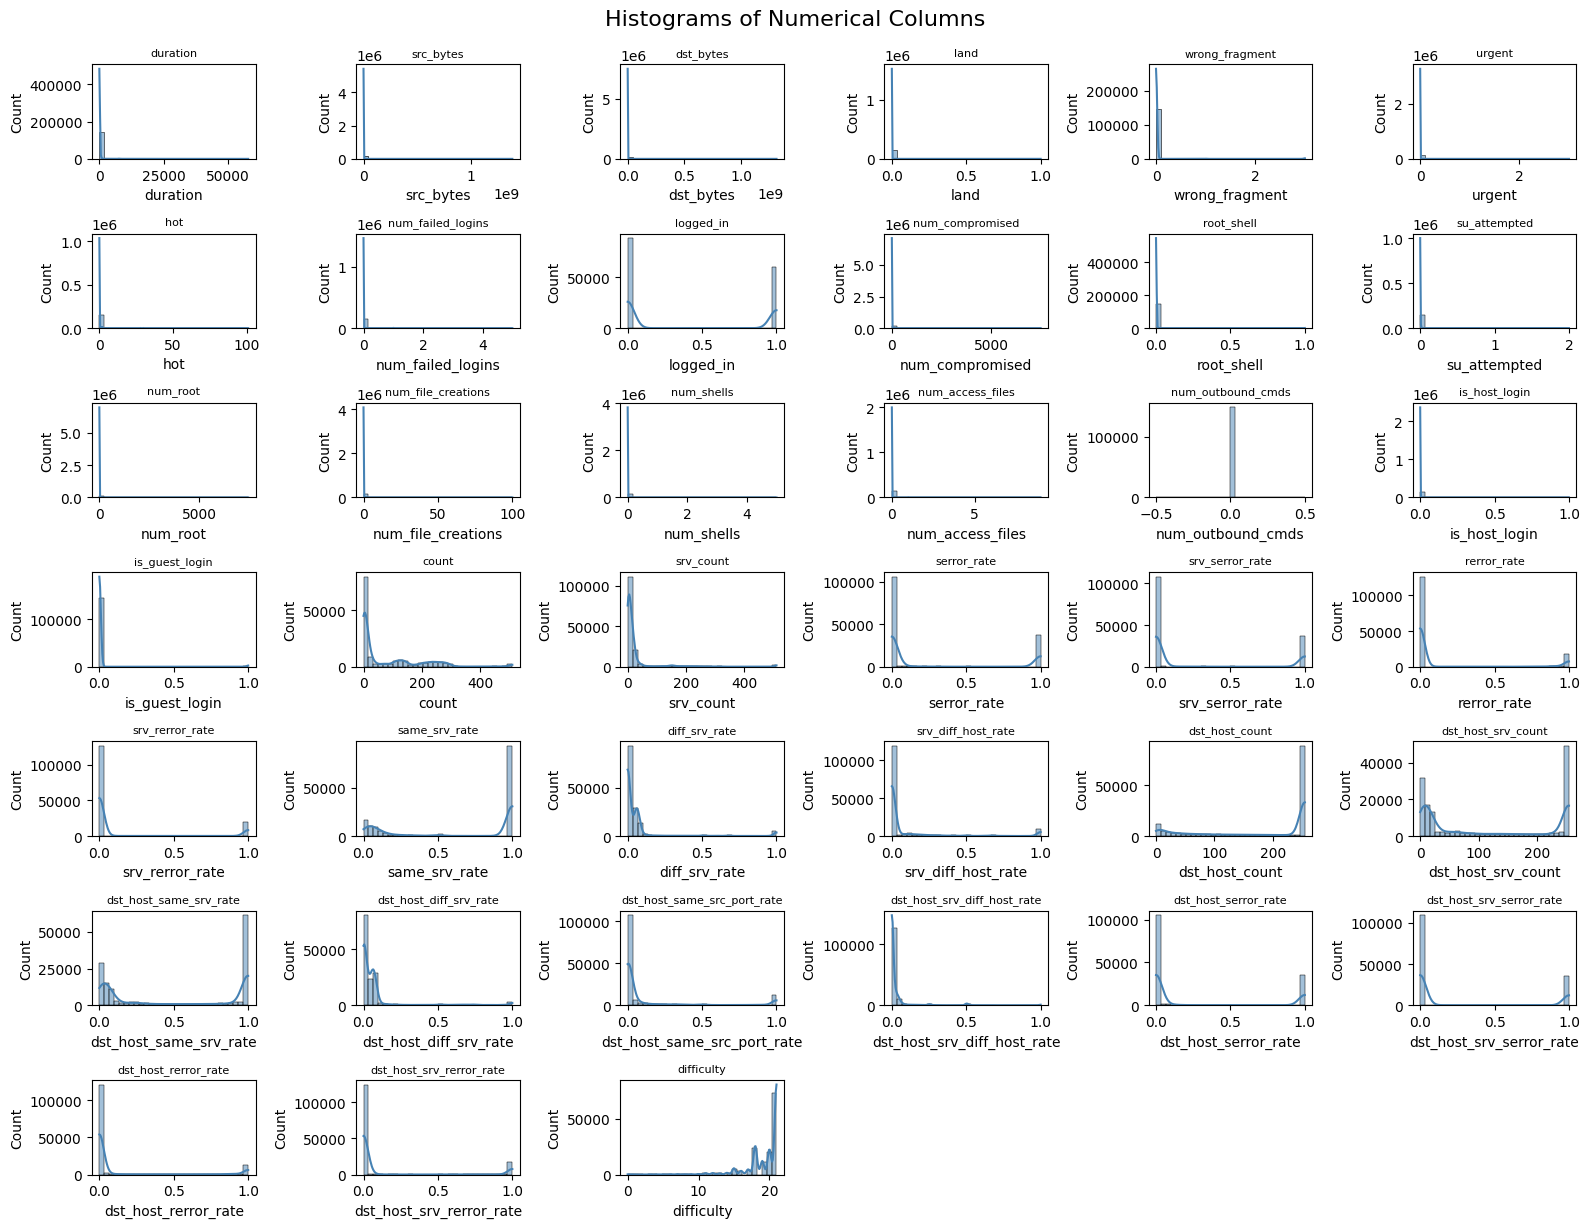

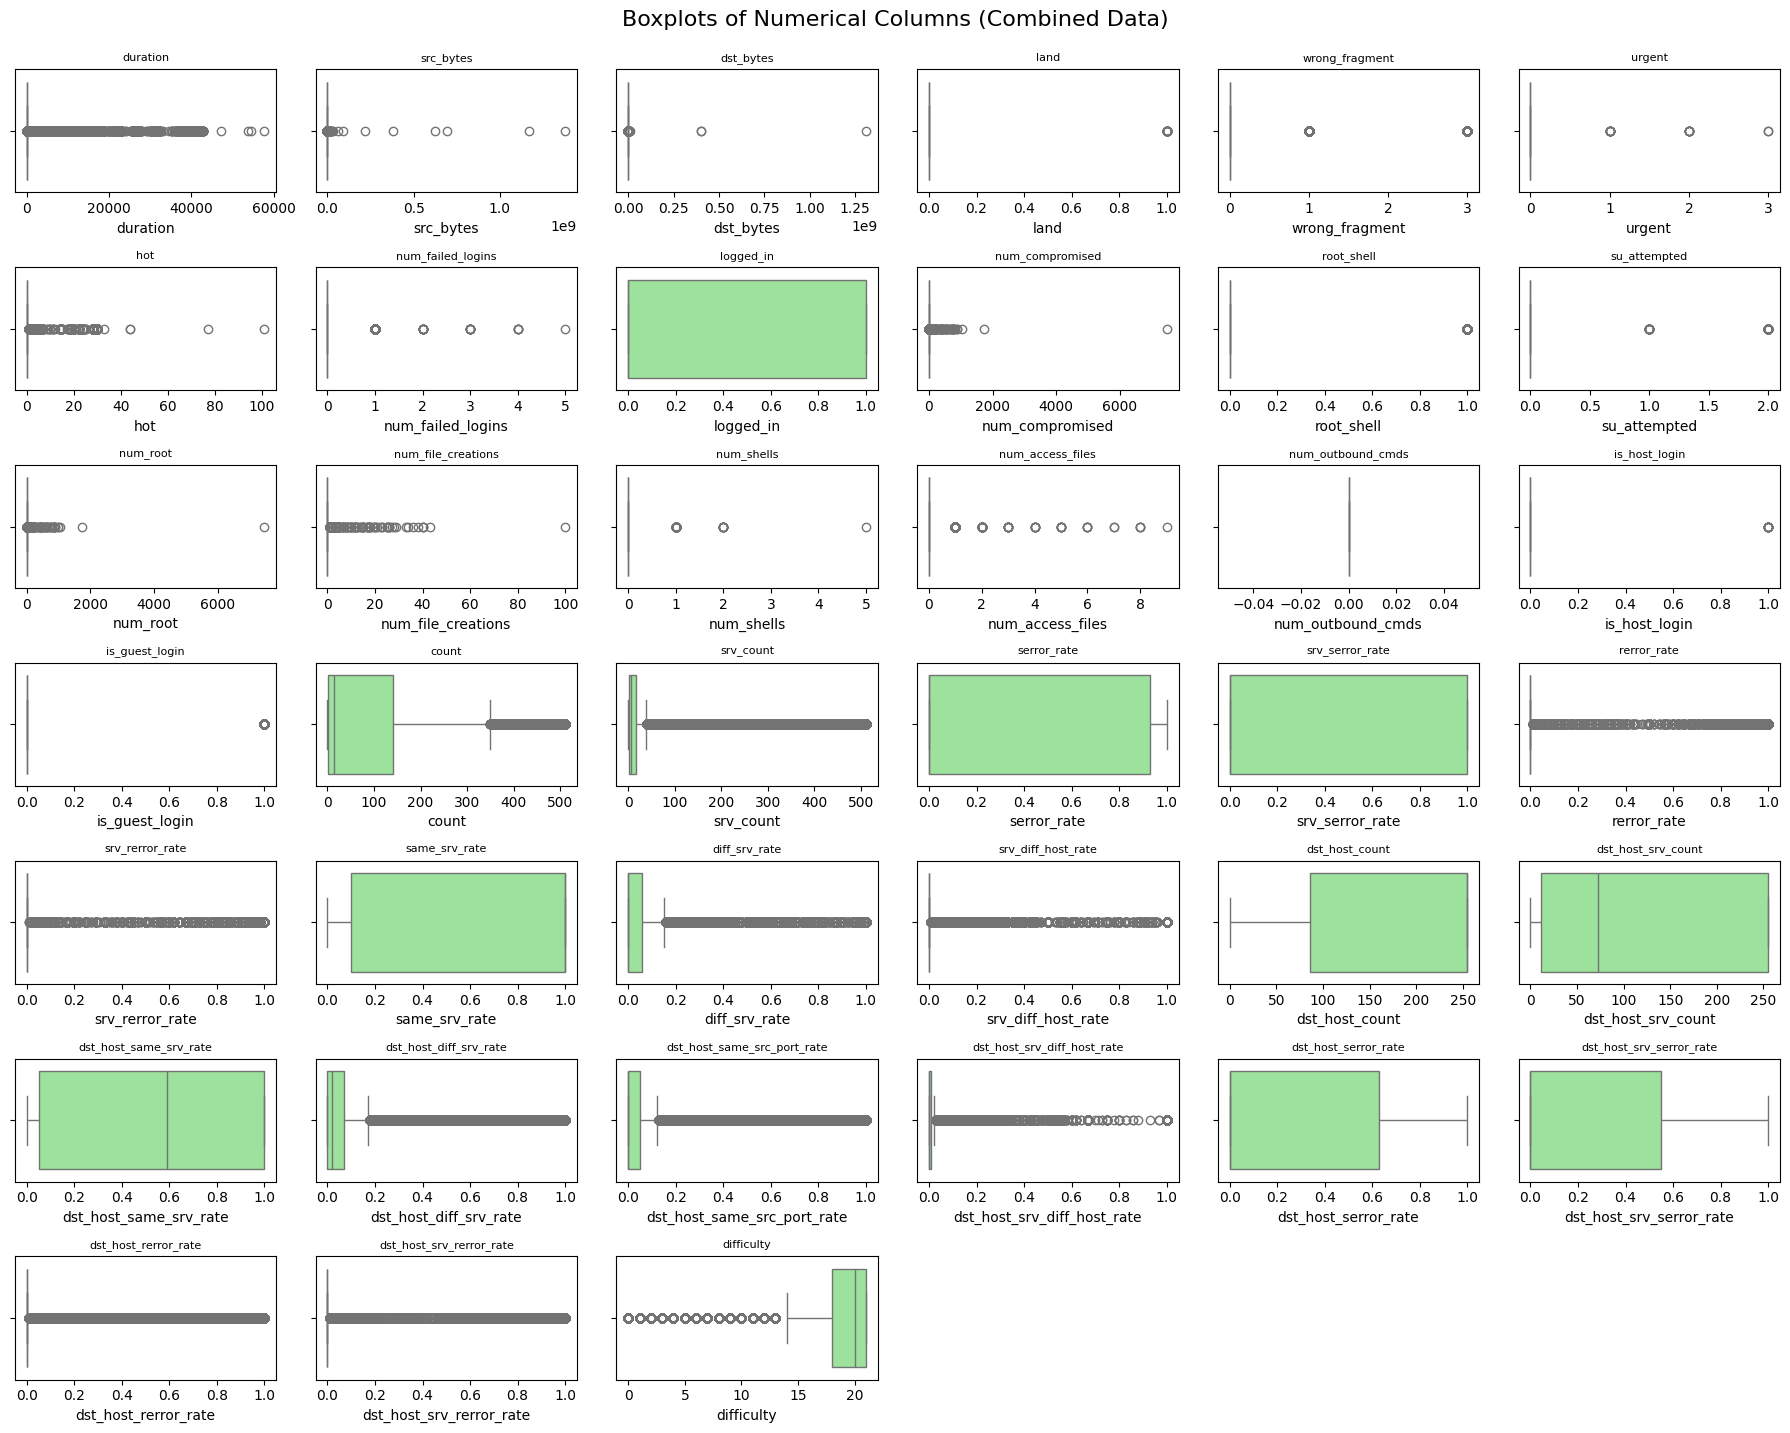

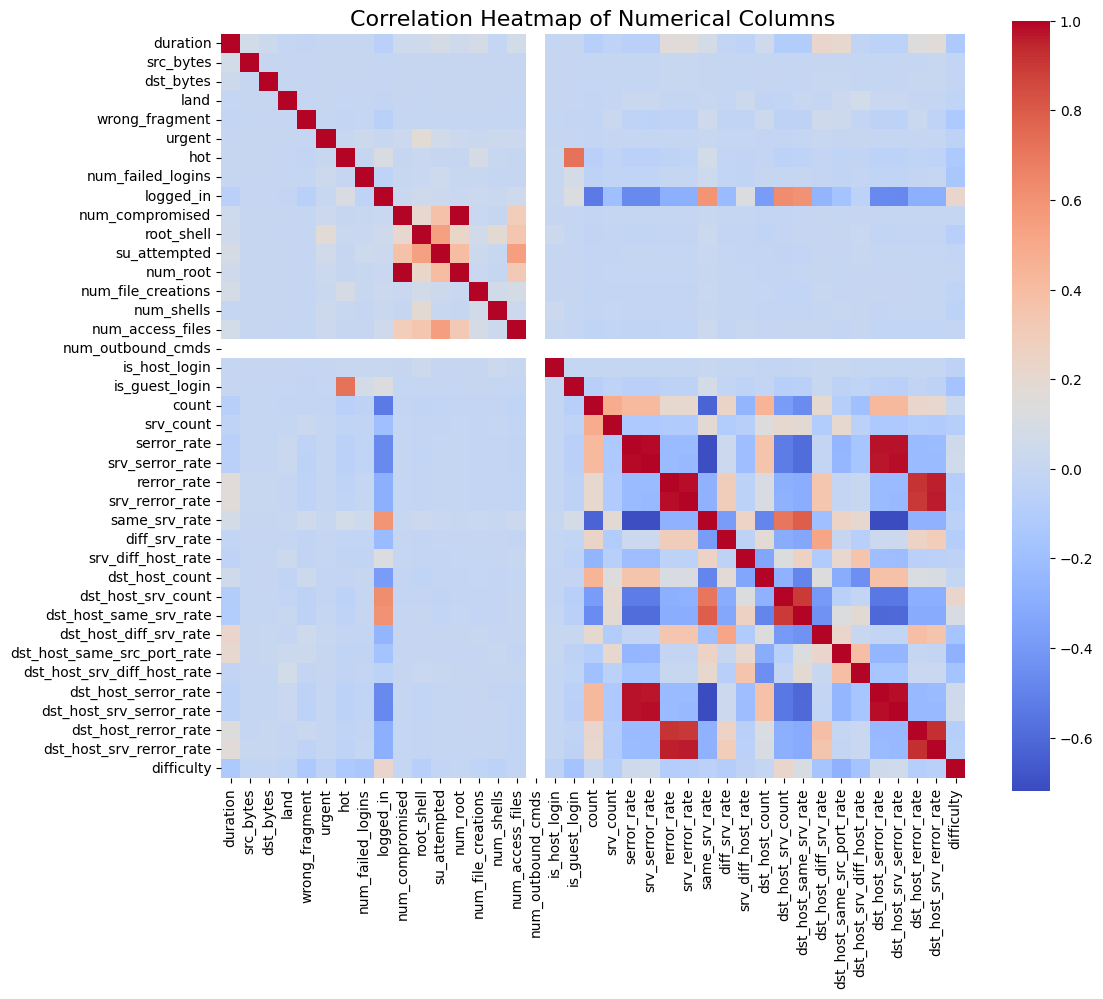

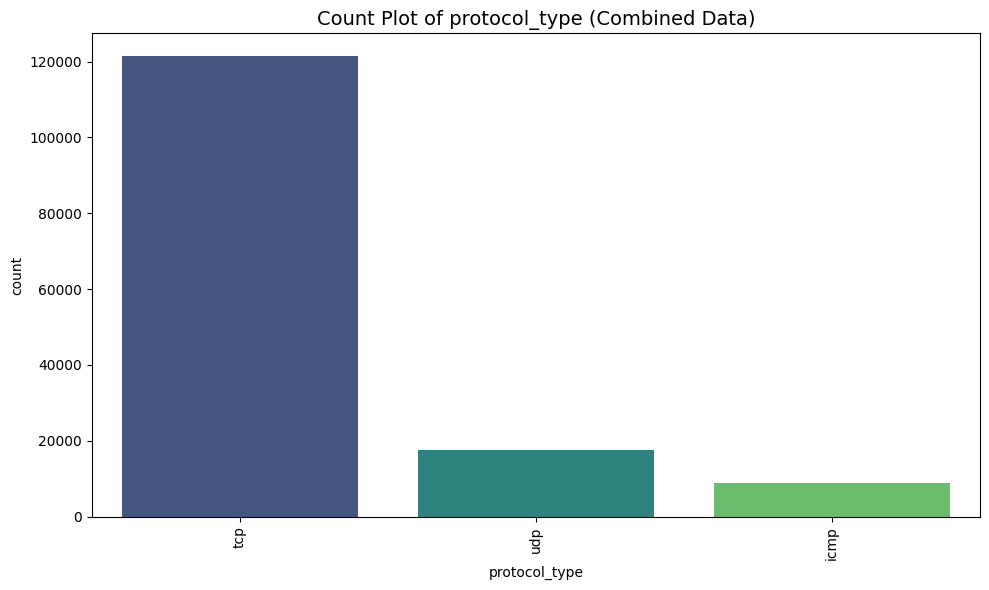

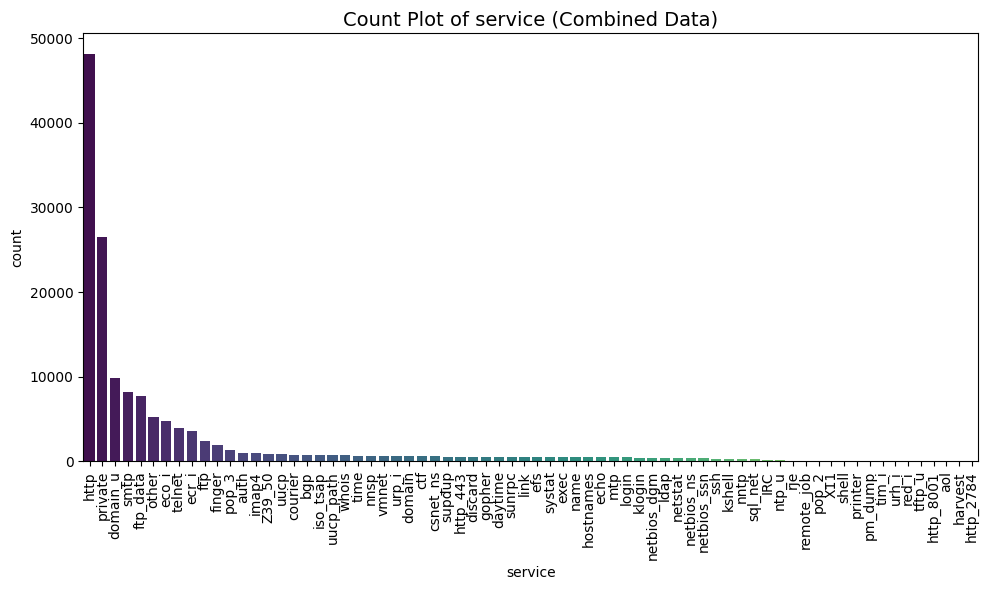

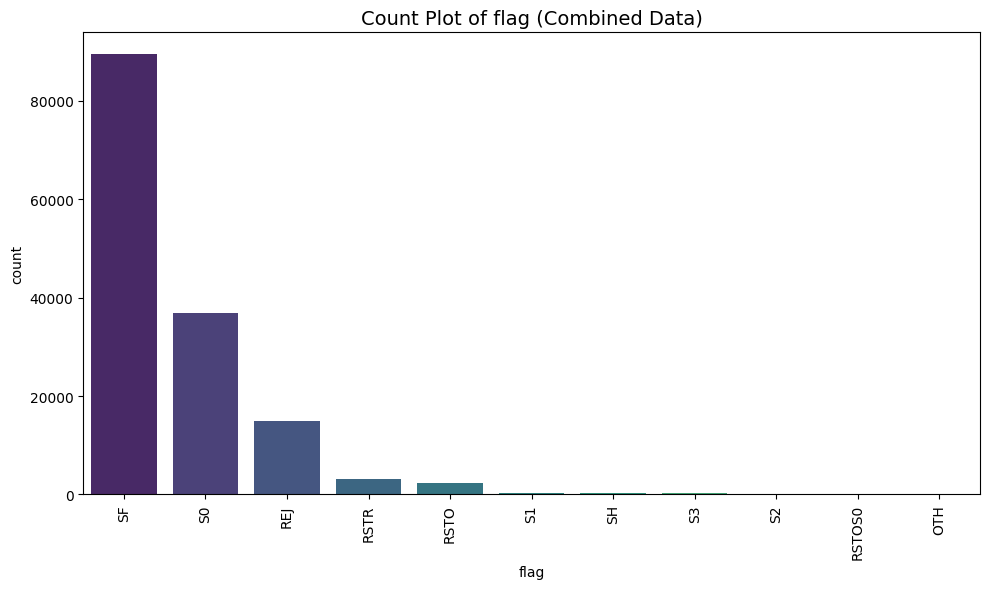

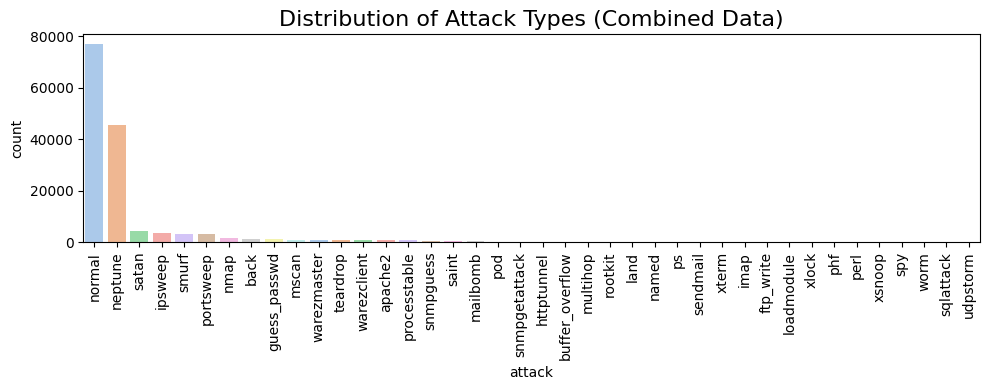

In [27]:
# Visualize numerical features: Histograms and Boxplots

num_cols = combined_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [col for col in combined_df.columns if col not in num_cols]

# Histograms
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(7, 6, i+1)
    sns.histplot(combined_df[col], bins=30, kde=True, color='steelblue')
    plt.title(col, fontsize=8)
    plt.tight_layout()
plt.suptitle("Histograms of Numerical Columns", fontsize=16, y=1.02)
plt.show()

# Boxplots
plt.figure(figsize=(18, 14))
for i, col in enumerate(num_cols):
    plt.subplot(7, 6, i+1)
    sns.boxplot(x=combined_df[col], color='lightgreen')
    plt.title(col, fontsize=8)
    plt.tight_layout()
plt.suptitle("Boxplots of Numerical Columns (Combined Data)", fontsize=16, y=1.02)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = combined_df[num_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numerical Columns", fontsize=16)
plt.show()

# Count plots for categorical features (except 'attack')
for col in cat_cols:
    if col == "attack":
        continue
    plt.figure(figsize=(10, 6))
    order = combined_df[col].value_counts().index
    sns.countplot(data=combined_df, x=col, order=order, palette="viridis")
    plt.title(f"Count Plot of {col} (Combined Data)", fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Distribution of attack types
plt.figure(figsize=(10, 4))
order = combined_df['attack'].value_counts().index
sns.countplot(data=combined_df, x='attack', order=order, palette="pastel")
plt.title("Distribution of Attack Types (Combined Data)", fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Data Transformation

In [28]:
# Create a binary label for classification: 0 for 'normal', 1 for any attack.
combined_df['binary_class'] = combined_df['attack'].apply(lambda x: 0 if x.lower() == 'normal' else 1)

# Separate target and features
y = combined_df['binary_class']
X = combined_df.drop(columns=['attack', 'difficulty', 'binary_class'])

# Identify numerical and categorical columns again
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(include=[object]).columns.tolist()

print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)

Numerical Columns: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
Categorical Columns: ['protocol_type', 'service', 'flag']


In [29]:
# One-Hot Encoding of categorical features and preserving feature names.
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = enc.fit_transform(X[categorical_columns])
cat_feature_names = list(enc.get_feature_names_out(categorical_columns))

# Get numerical part as array and preserve their names.
X_num = X[numerical_columns].values
num_feature_names = numerical_columns

# Concatenate numerical and categorical features.
X_transformed = np.hstack([X_num, X_cat])
final_feature_names = num_feature_names + cat_feature_names

# Scale the features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

print("Final transformed feature shape:", X_scaled.shape)

Final transformed feature shape: (147907, 122)


In [30]:
# Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: (88744, 122) X_test shape: (59163, 122)


# Feature Selection Using Mutual Information

In [31]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Select top 100 features from the combined set.
selector = SelectKBest(score_func=mutual_info_classif, k=100)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print("Original feature dimension:", X_train.shape[1])
print("Selected feature dimension:", X_train_selected.shape[1])

# Map selected indices back to feature names.
selected_indices = selector.get_support(indices=True)
selected_feature_names = [final_feature_names[i] for i in selected_indices]
print("\nSelected Feature Names:")
print(selected_feature_names)

Original feature dimension: 122
Selected feature dimension: 100

Selected Feature Names:
['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_access_files', 'num_outbound_cmds', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp', 'service_IRC', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'servi

# Model Training and Evaluation


Training AdaBoost...
AdaBoost Accuracy: 0.9525
AdaBoost Confusion Matrix:
[[29647  1140]
 [ 1668 26708]]
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9467    0.9630    0.9548     30787
           1     0.9591    0.9412    0.9501     28376

    accuracy                         0.9525     59163
   macro avg     0.9529    0.9521    0.9524     59163
weighted avg     0.9526    0.9525    0.9525     59163



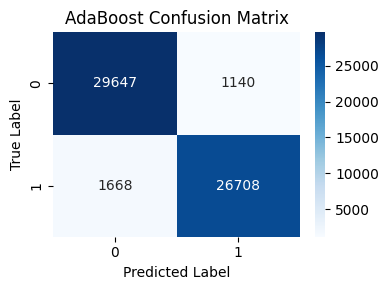


Training Extra Trees...
Extra Trees Accuracy: 0.9949
Extra Trees Confusion Matrix:
[[30671   116]
 [  185 28191]]
Extra Trees Classification Report:
              precision    recall  f1-score   support

           0     0.9940    0.9962    0.9951     30787
           1     0.9959    0.9935    0.9947     28376

    accuracy                         0.9949     59163
   macro avg     0.9950    0.9949    0.9949     59163
weighted avg     0.9949    0.9949    0.9949     59163



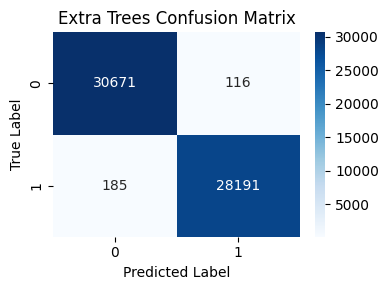


Training Gradient Boost...
Gradient Boost Accuracy: 0.9894
Gradient Boost Confusion Matrix:
[[30503   284]
 [  346 28030]]
Gradient Boost Classification Report:
              precision    recall  f1-score   support

           0     0.9888    0.9908    0.9898     30787
           1     0.9900    0.9878    0.9889     28376

    accuracy                         0.9894     59163
   macro avg     0.9894    0.9893    0.9893     59163
weighted avg     0.9894    0.9894    0.9894     59163



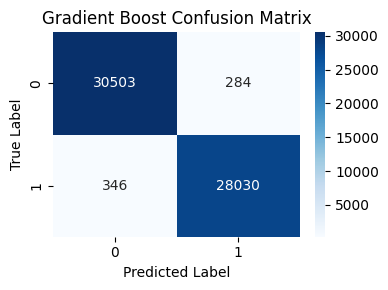


Training Random Forest...
Random Forest Accuracy: 0.9957
Random Forest Confusion Matrix:
[[30695    92]
 [  164 28212]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9947    0.9970    0.9958     30787
           1     0.9967    0.9942    0.9955     28376

    accuracy                         0.9957     59163
   macro avg     0.9957    0.9956    0.9957     59163
weighted avg     0.9957    0.9957    0.9957     59163



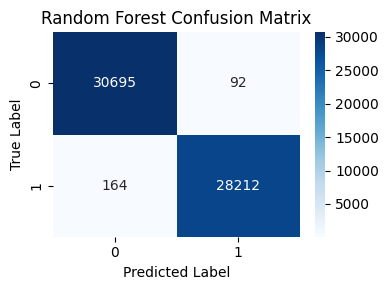


Training MLP...
MLP Accuracy: 0.9910
MLP Confusion Matrix:
[[30450   337]
 [  195 28181]]
MLP Classification Report:
              precision    recall  f1-score   support

           0     0.9936    0.9891    0.9913     30787
           1     0.9882    0.9931    0.9906     28376

    accuracy                         0.9910     59163
   macro avg     0.9909    0.9911    0.9910     59163
weighted avg     0.9910    0.9910    0.9910     59163



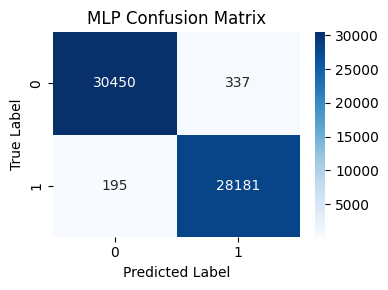


Training Linear Regression...
Linear Regression Accuracy (thresholded at 0.5): 0.9462
Linear Regression Confusion Matrix:
[[29855   932]
 [ 2253 26123]]
Linear Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9298    0.9697    0.9494     30787
           1     0.9656    0.9206    0.9425     28376

    accuracy                         0.9462     59163
   macro avg     0.9477    0.9452    0.9460     59163
weighted avg     0.9470    0.9462    0.9461     59163



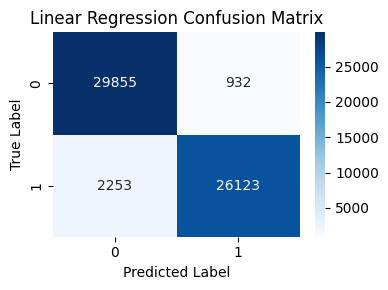


Summary of Accuracies:
AdaBoost: 0.9525
Extra Trees: 0.9949
Gradient Boost: 0.9894
Random Forest: 0.9957
MLP: 0.9910
Linear Regression: 0.9462


In [32]:
# Initialize the classifiers.
models = {
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "MLP": MLPClassifier(max_iter=300, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_selected, y_train)
    preds = model.predict(X_test_selected)
    
    # Accuracy
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    print(f"{name} Confusion Matrix:\n{cm}")
    
    # Classification Report
    cr = classification_report(y_test, preds, digits=4)
    print(f"{name} Classification Report:\n{cr}")
    
    # Plot Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Linear Regression (for comparison) - thresholding at 0.5
print("\nTraining Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_selected, y_train)
lr_preds = lr.predict(X_test_selected)
lr_preds_class = np.where(lr_preds > 0.5, 1, 0)
lr_acc = accuracy_score(y_test, lr_preds_class)
results["Linear Regression"] = lr_acc
print(f"Linear Regression Accuracy (thresholded at 0.5): {lr_acc:.4f}")

lr_cm = confusion_matrix(y_test, lr_preds_class)
print(f"Linear Regression Confusion Matrix:\n{lr_cm}")
lr_cr = classification_report(y_test, lr_preds_class, digits=4)
print(f"Linear Regression Classification Report:\n{lr_cr}")

plt.figure(figsize=(4, 3))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Linear Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("\nSummary of Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Feature Importance Visualization


Visualizing feature importance for AdaBoost:


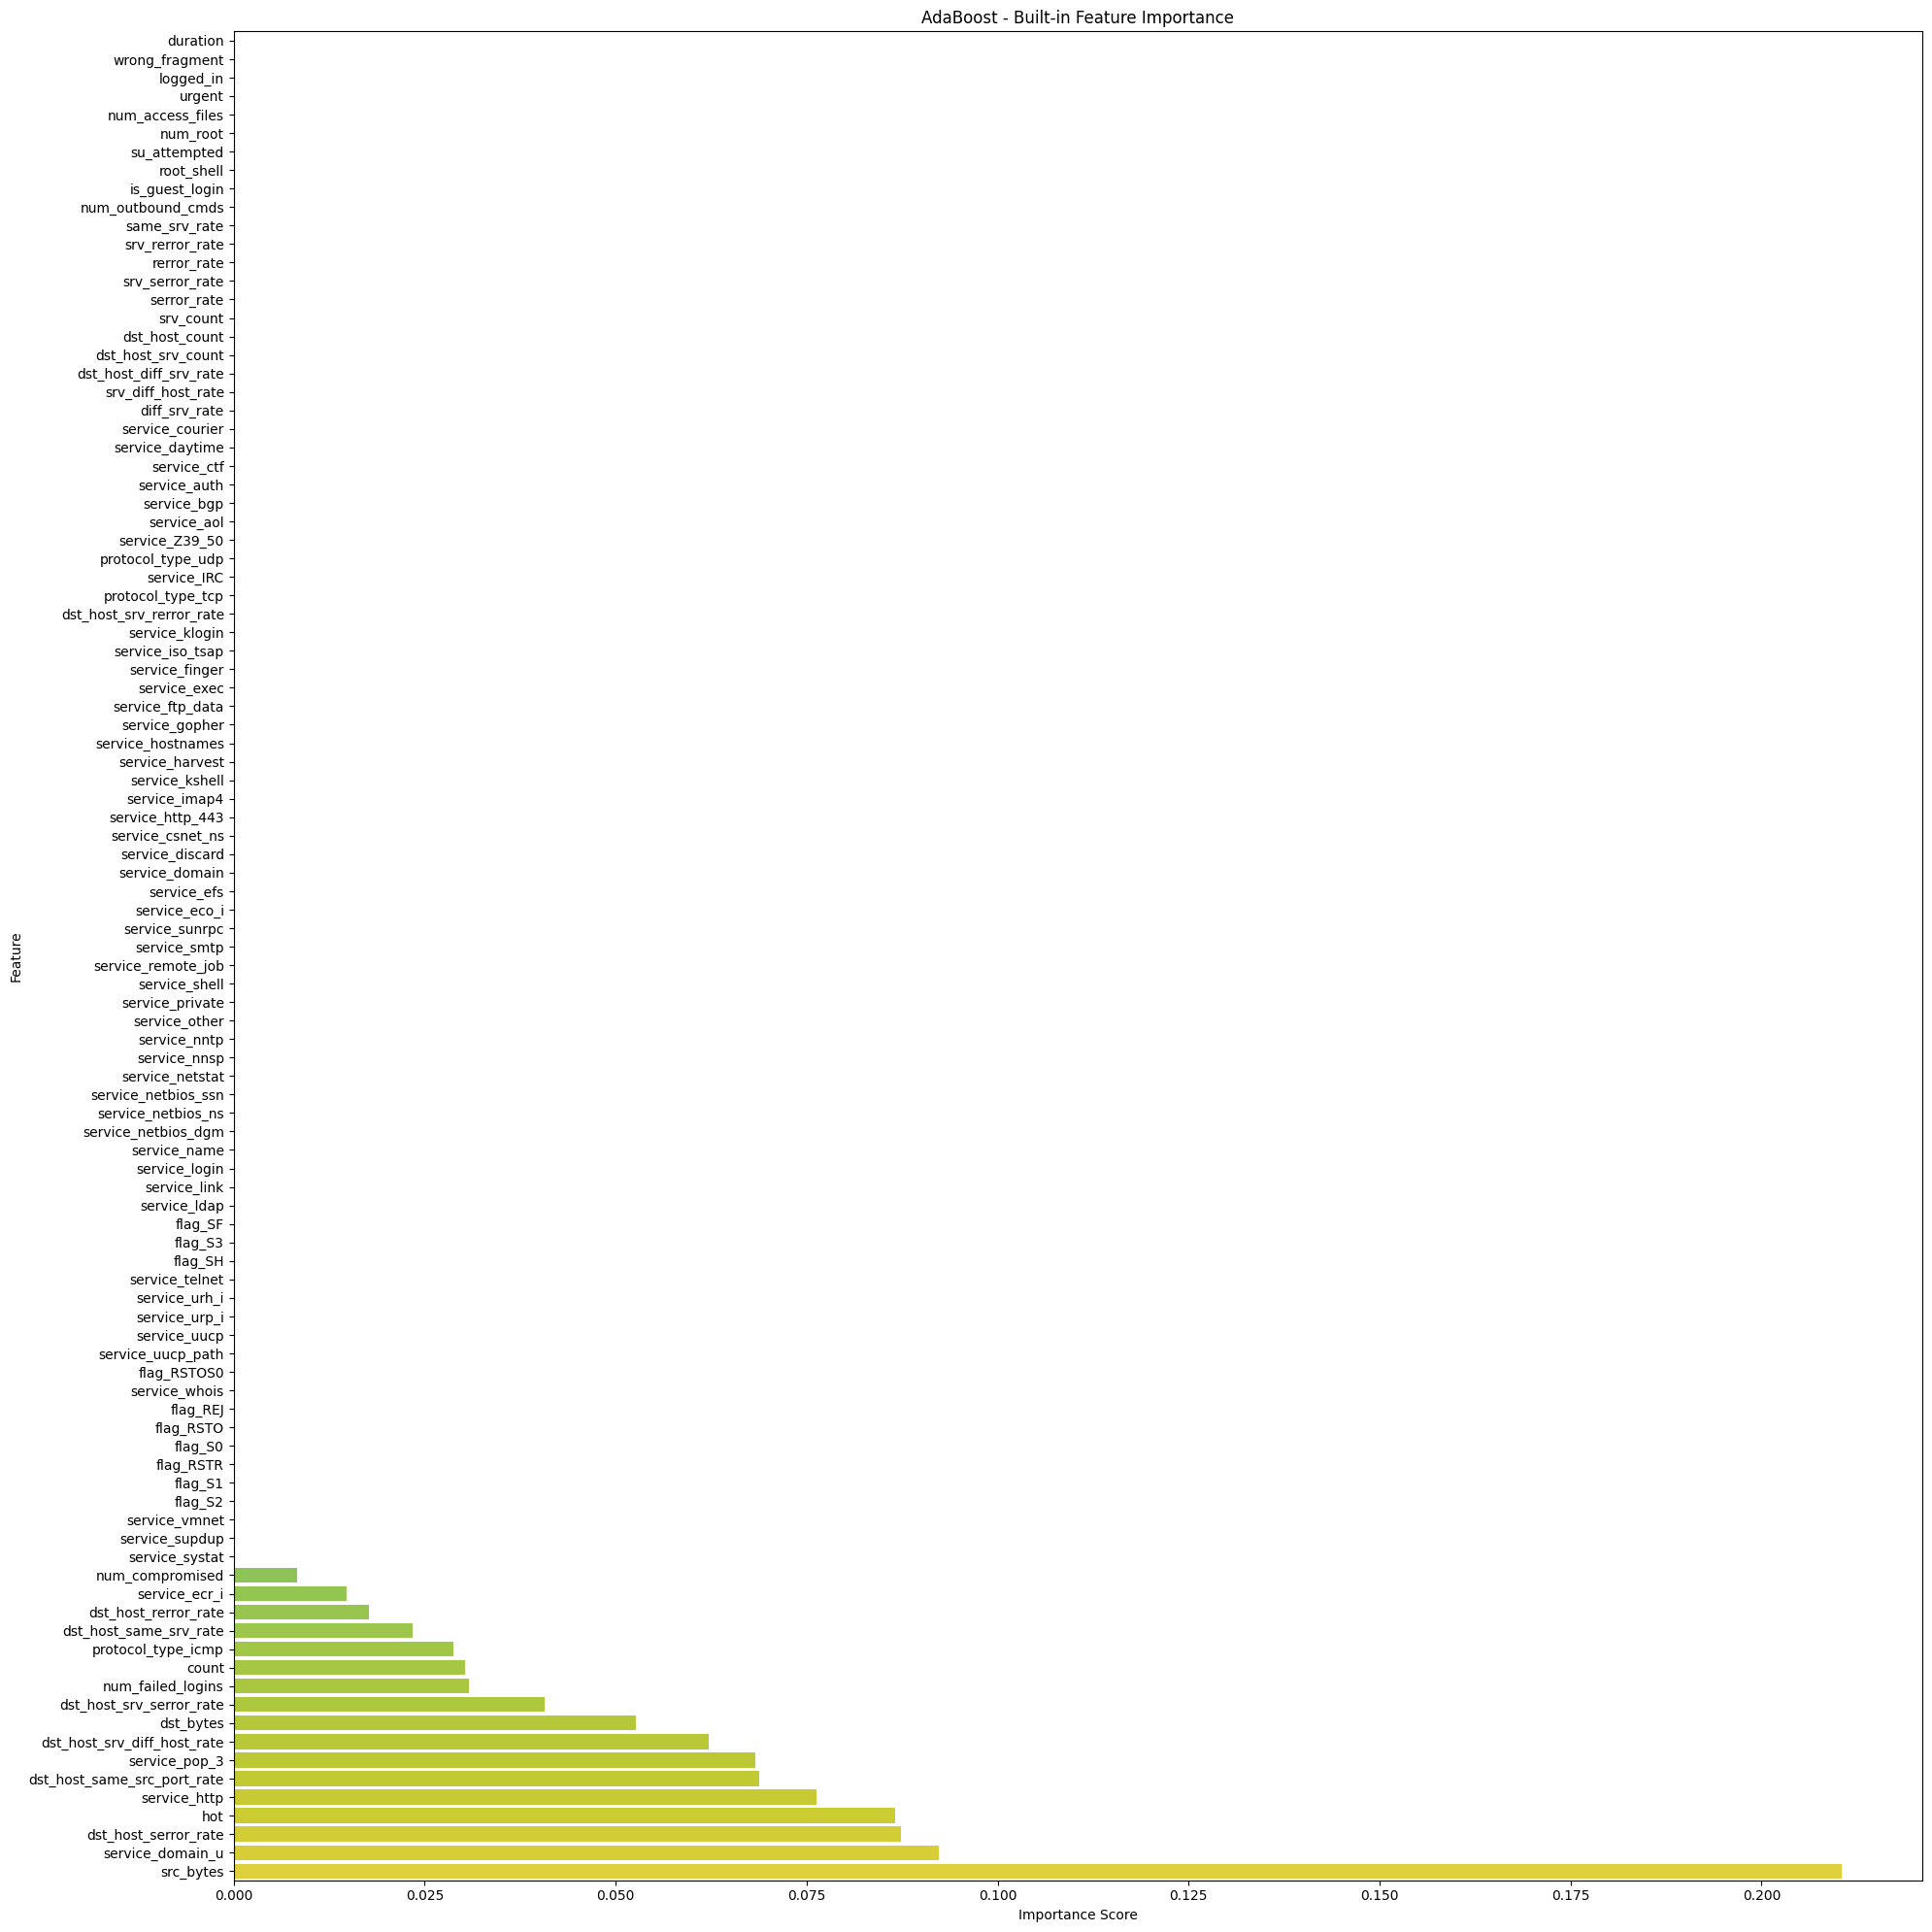


Visualizing feature importance for Extra Trees:


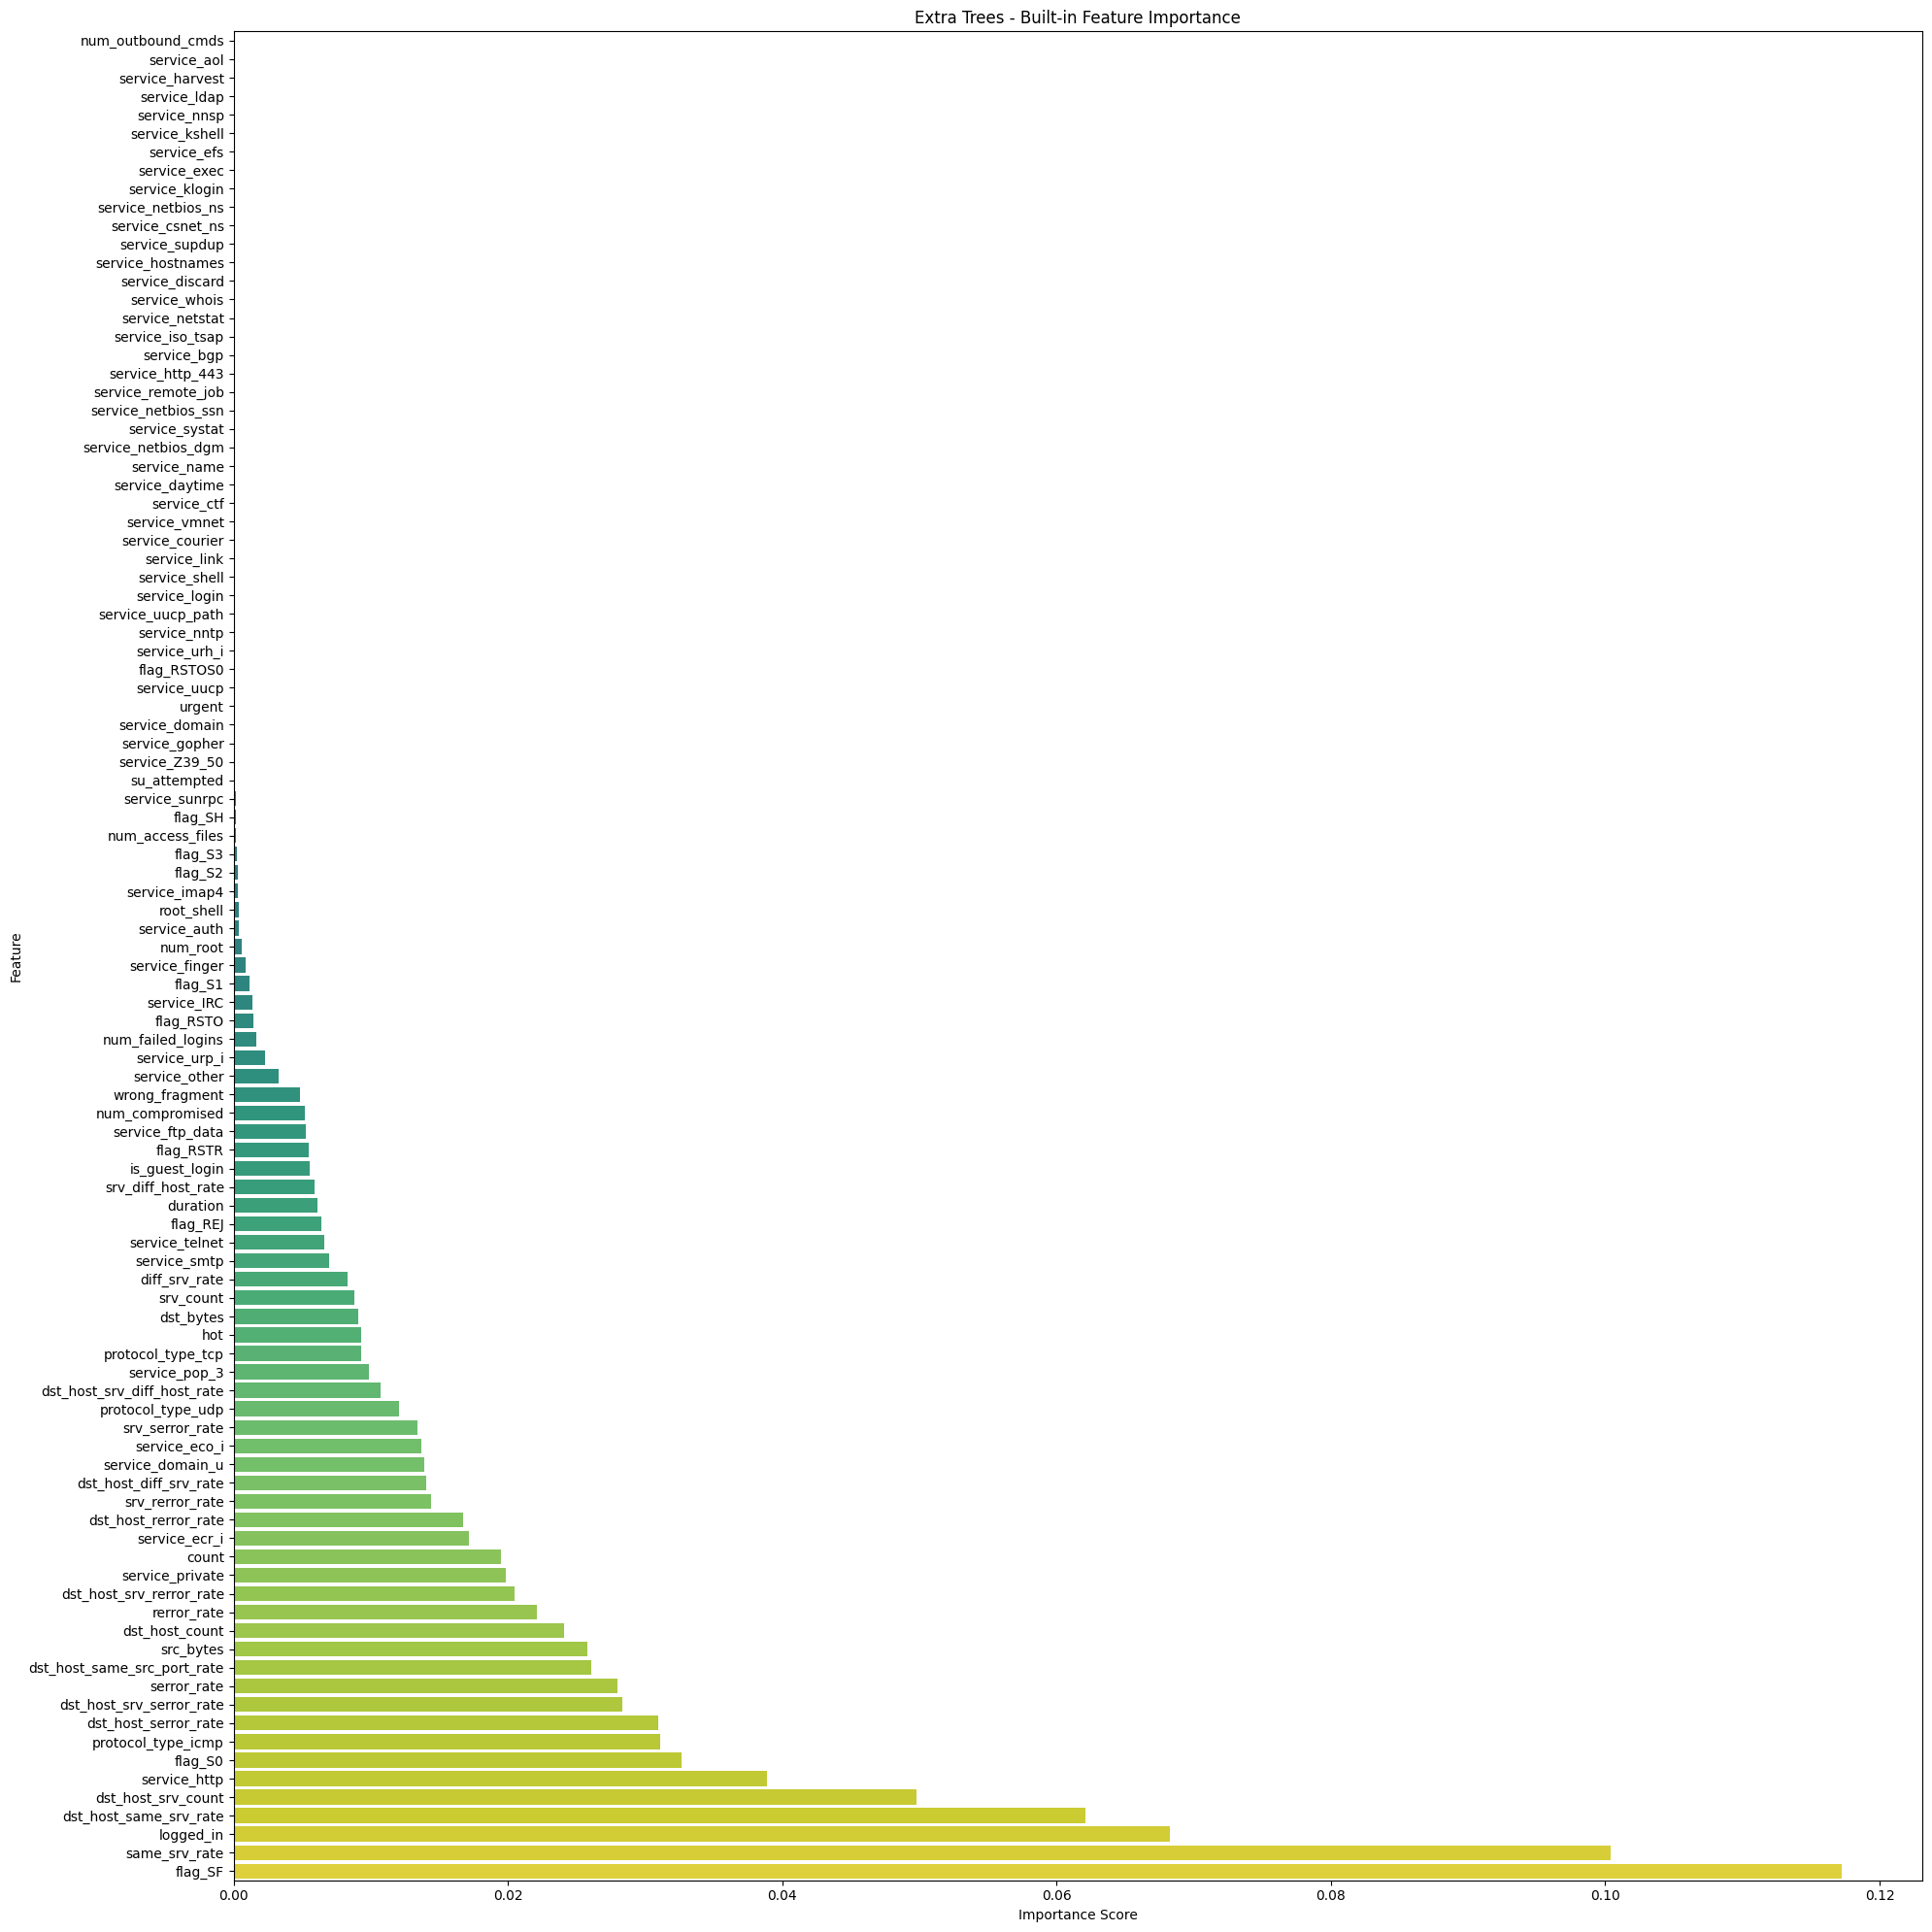


Visualizing feature importance for Gradient Boost:


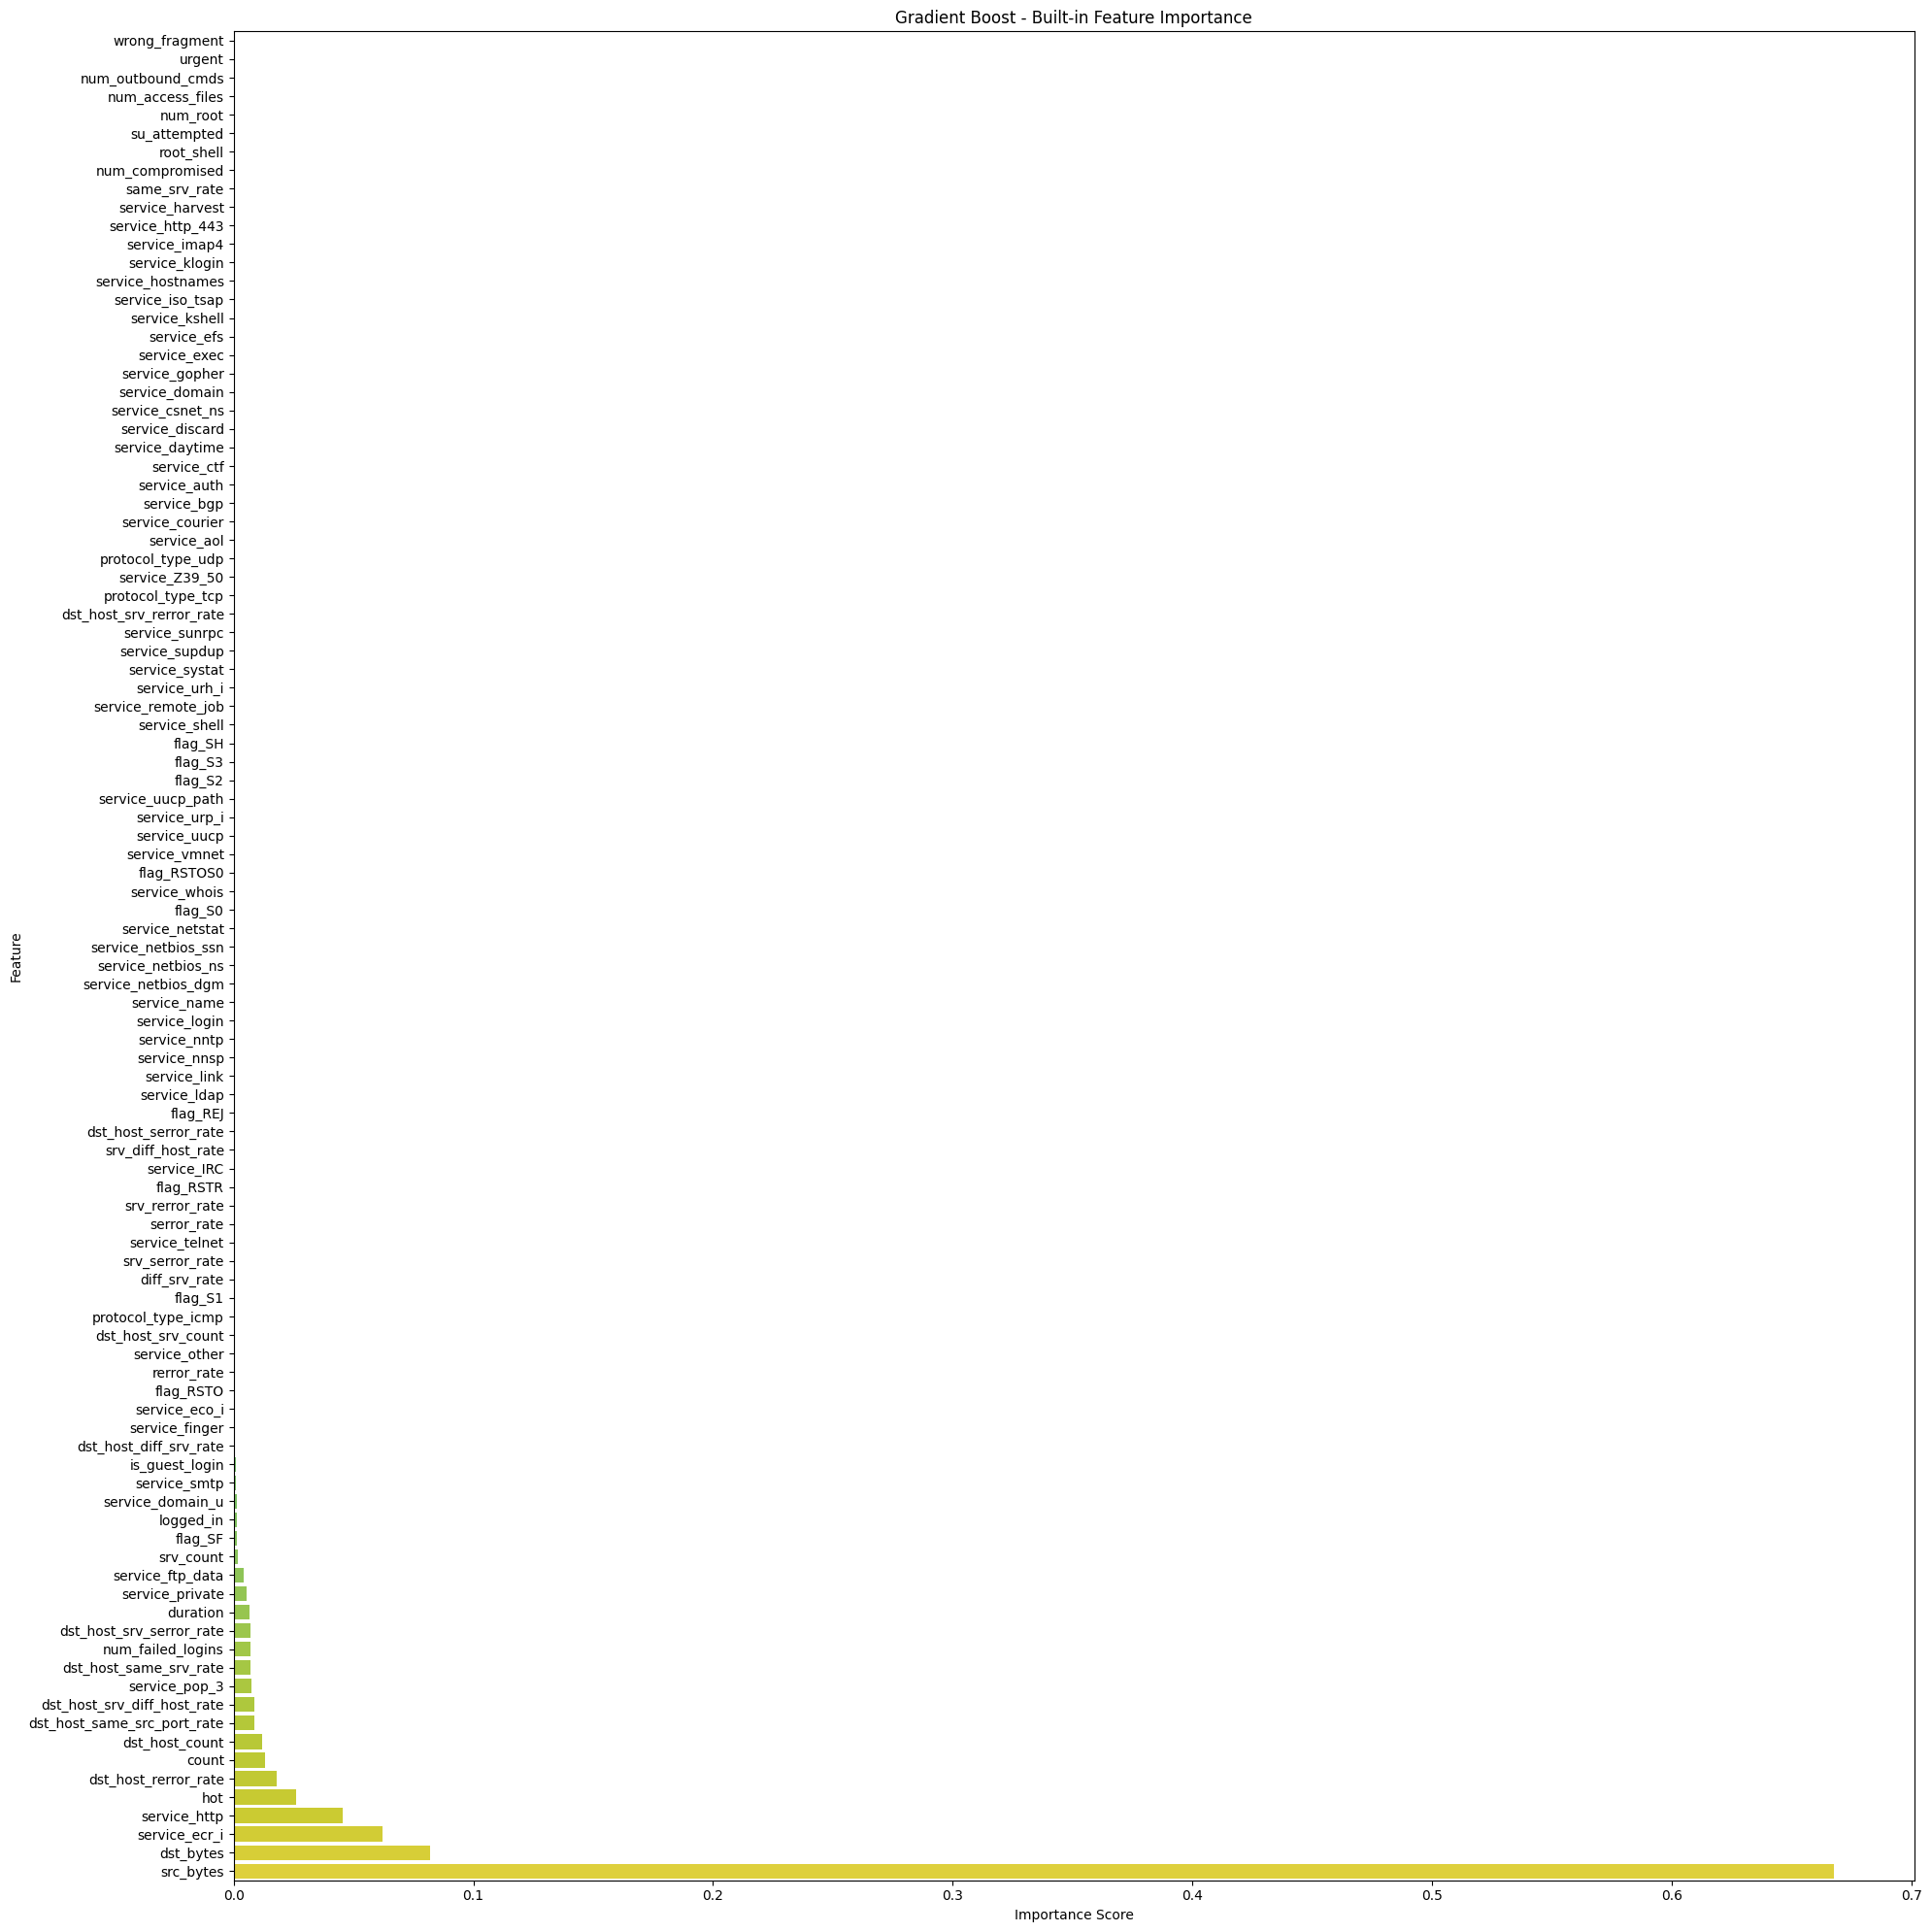


Visualizing feature importance for Random Forest:


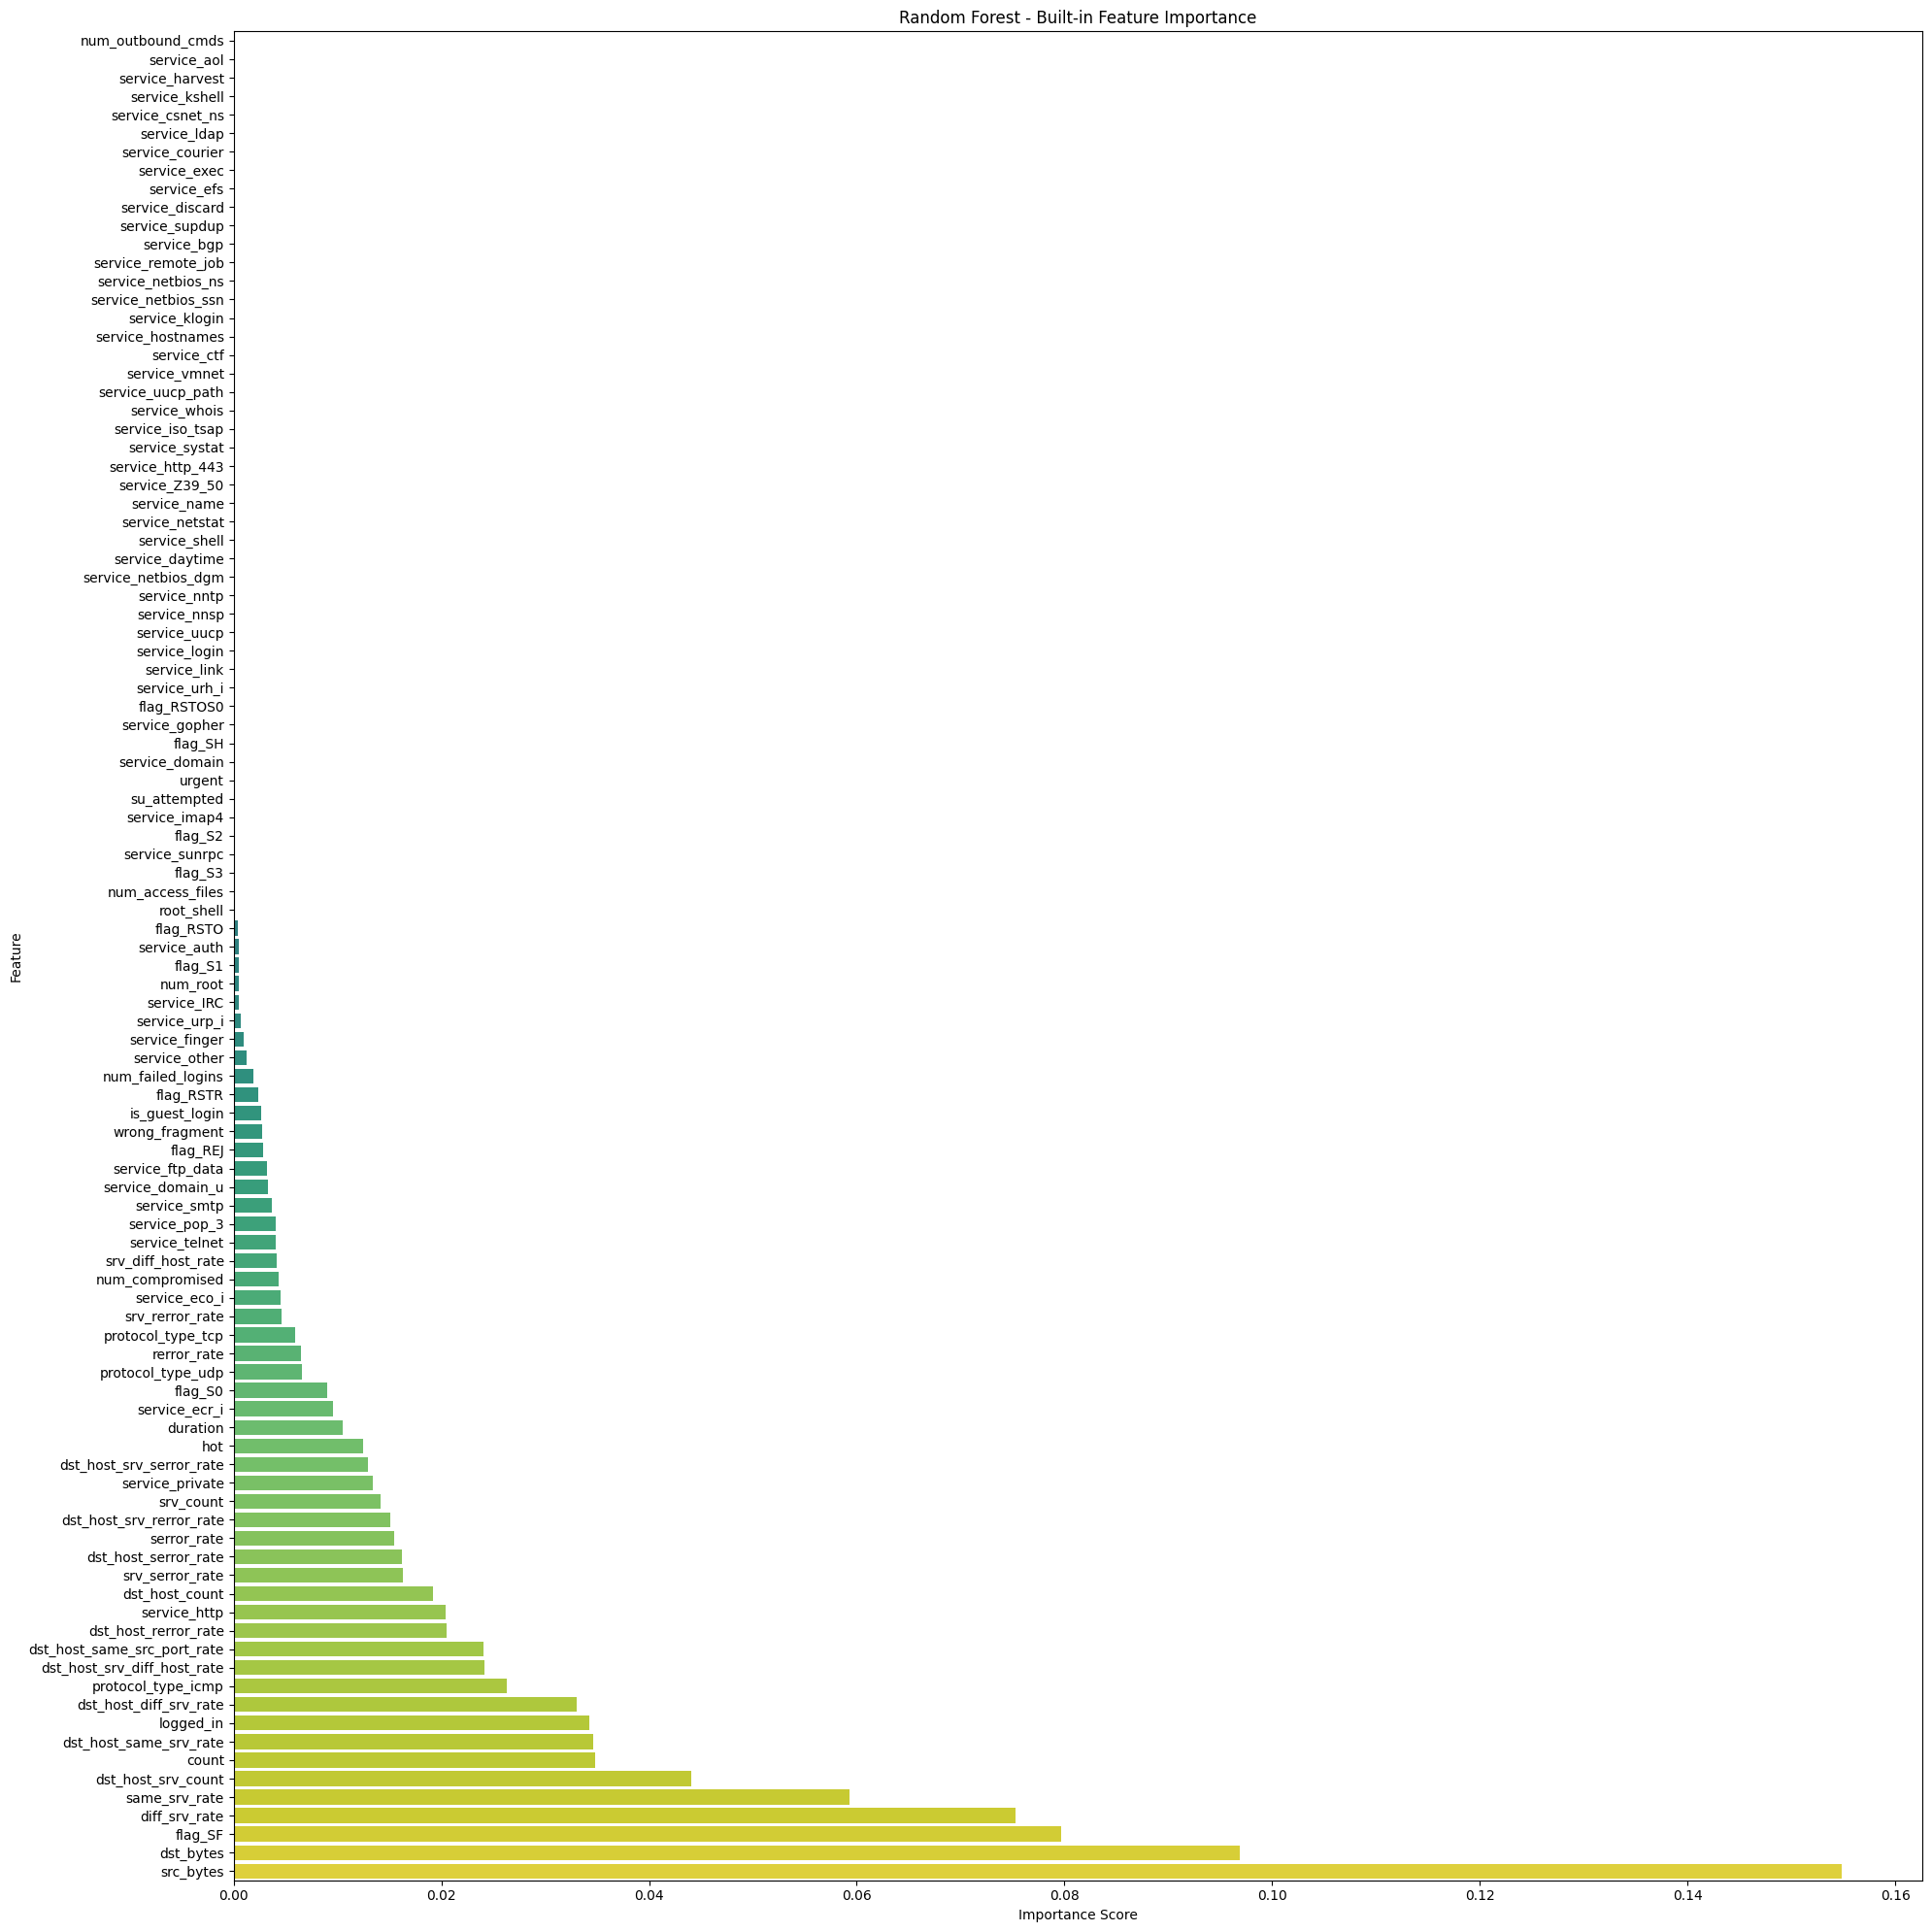


Visualizing feature importance for MLP:
MLP does not have built-in feature importance. Computing permutation importance.


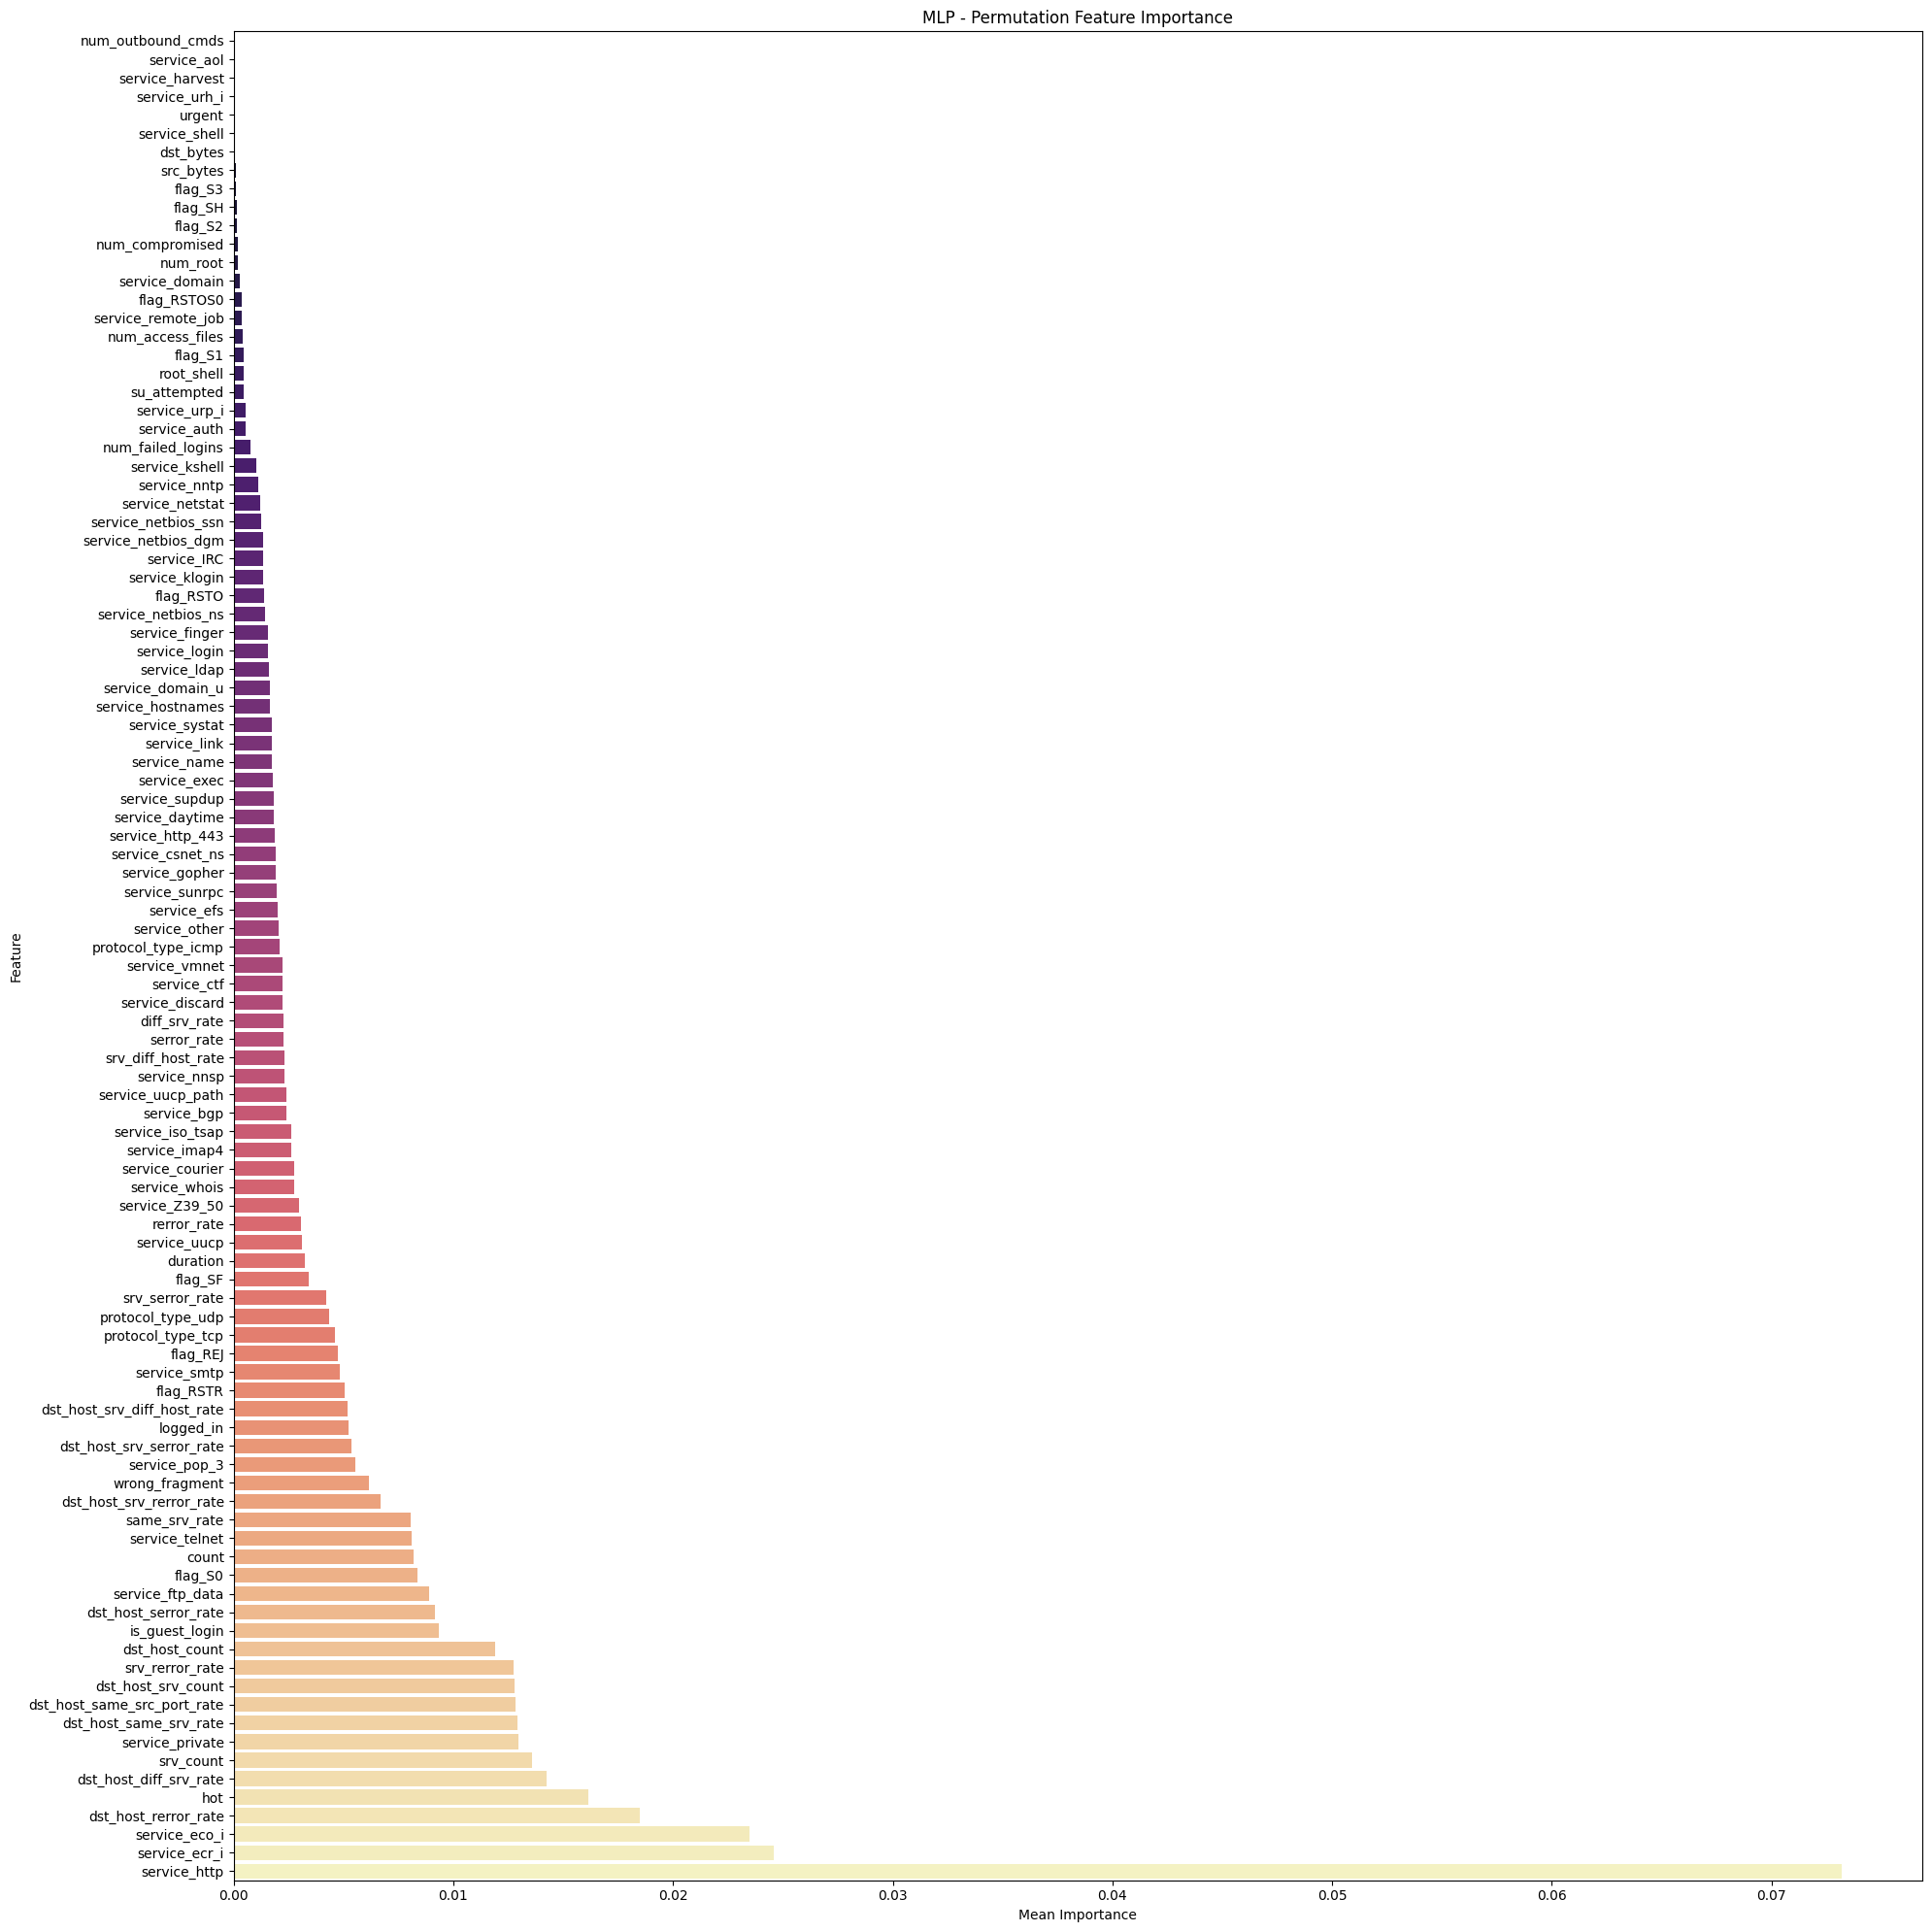


Permutation importance for MLP:


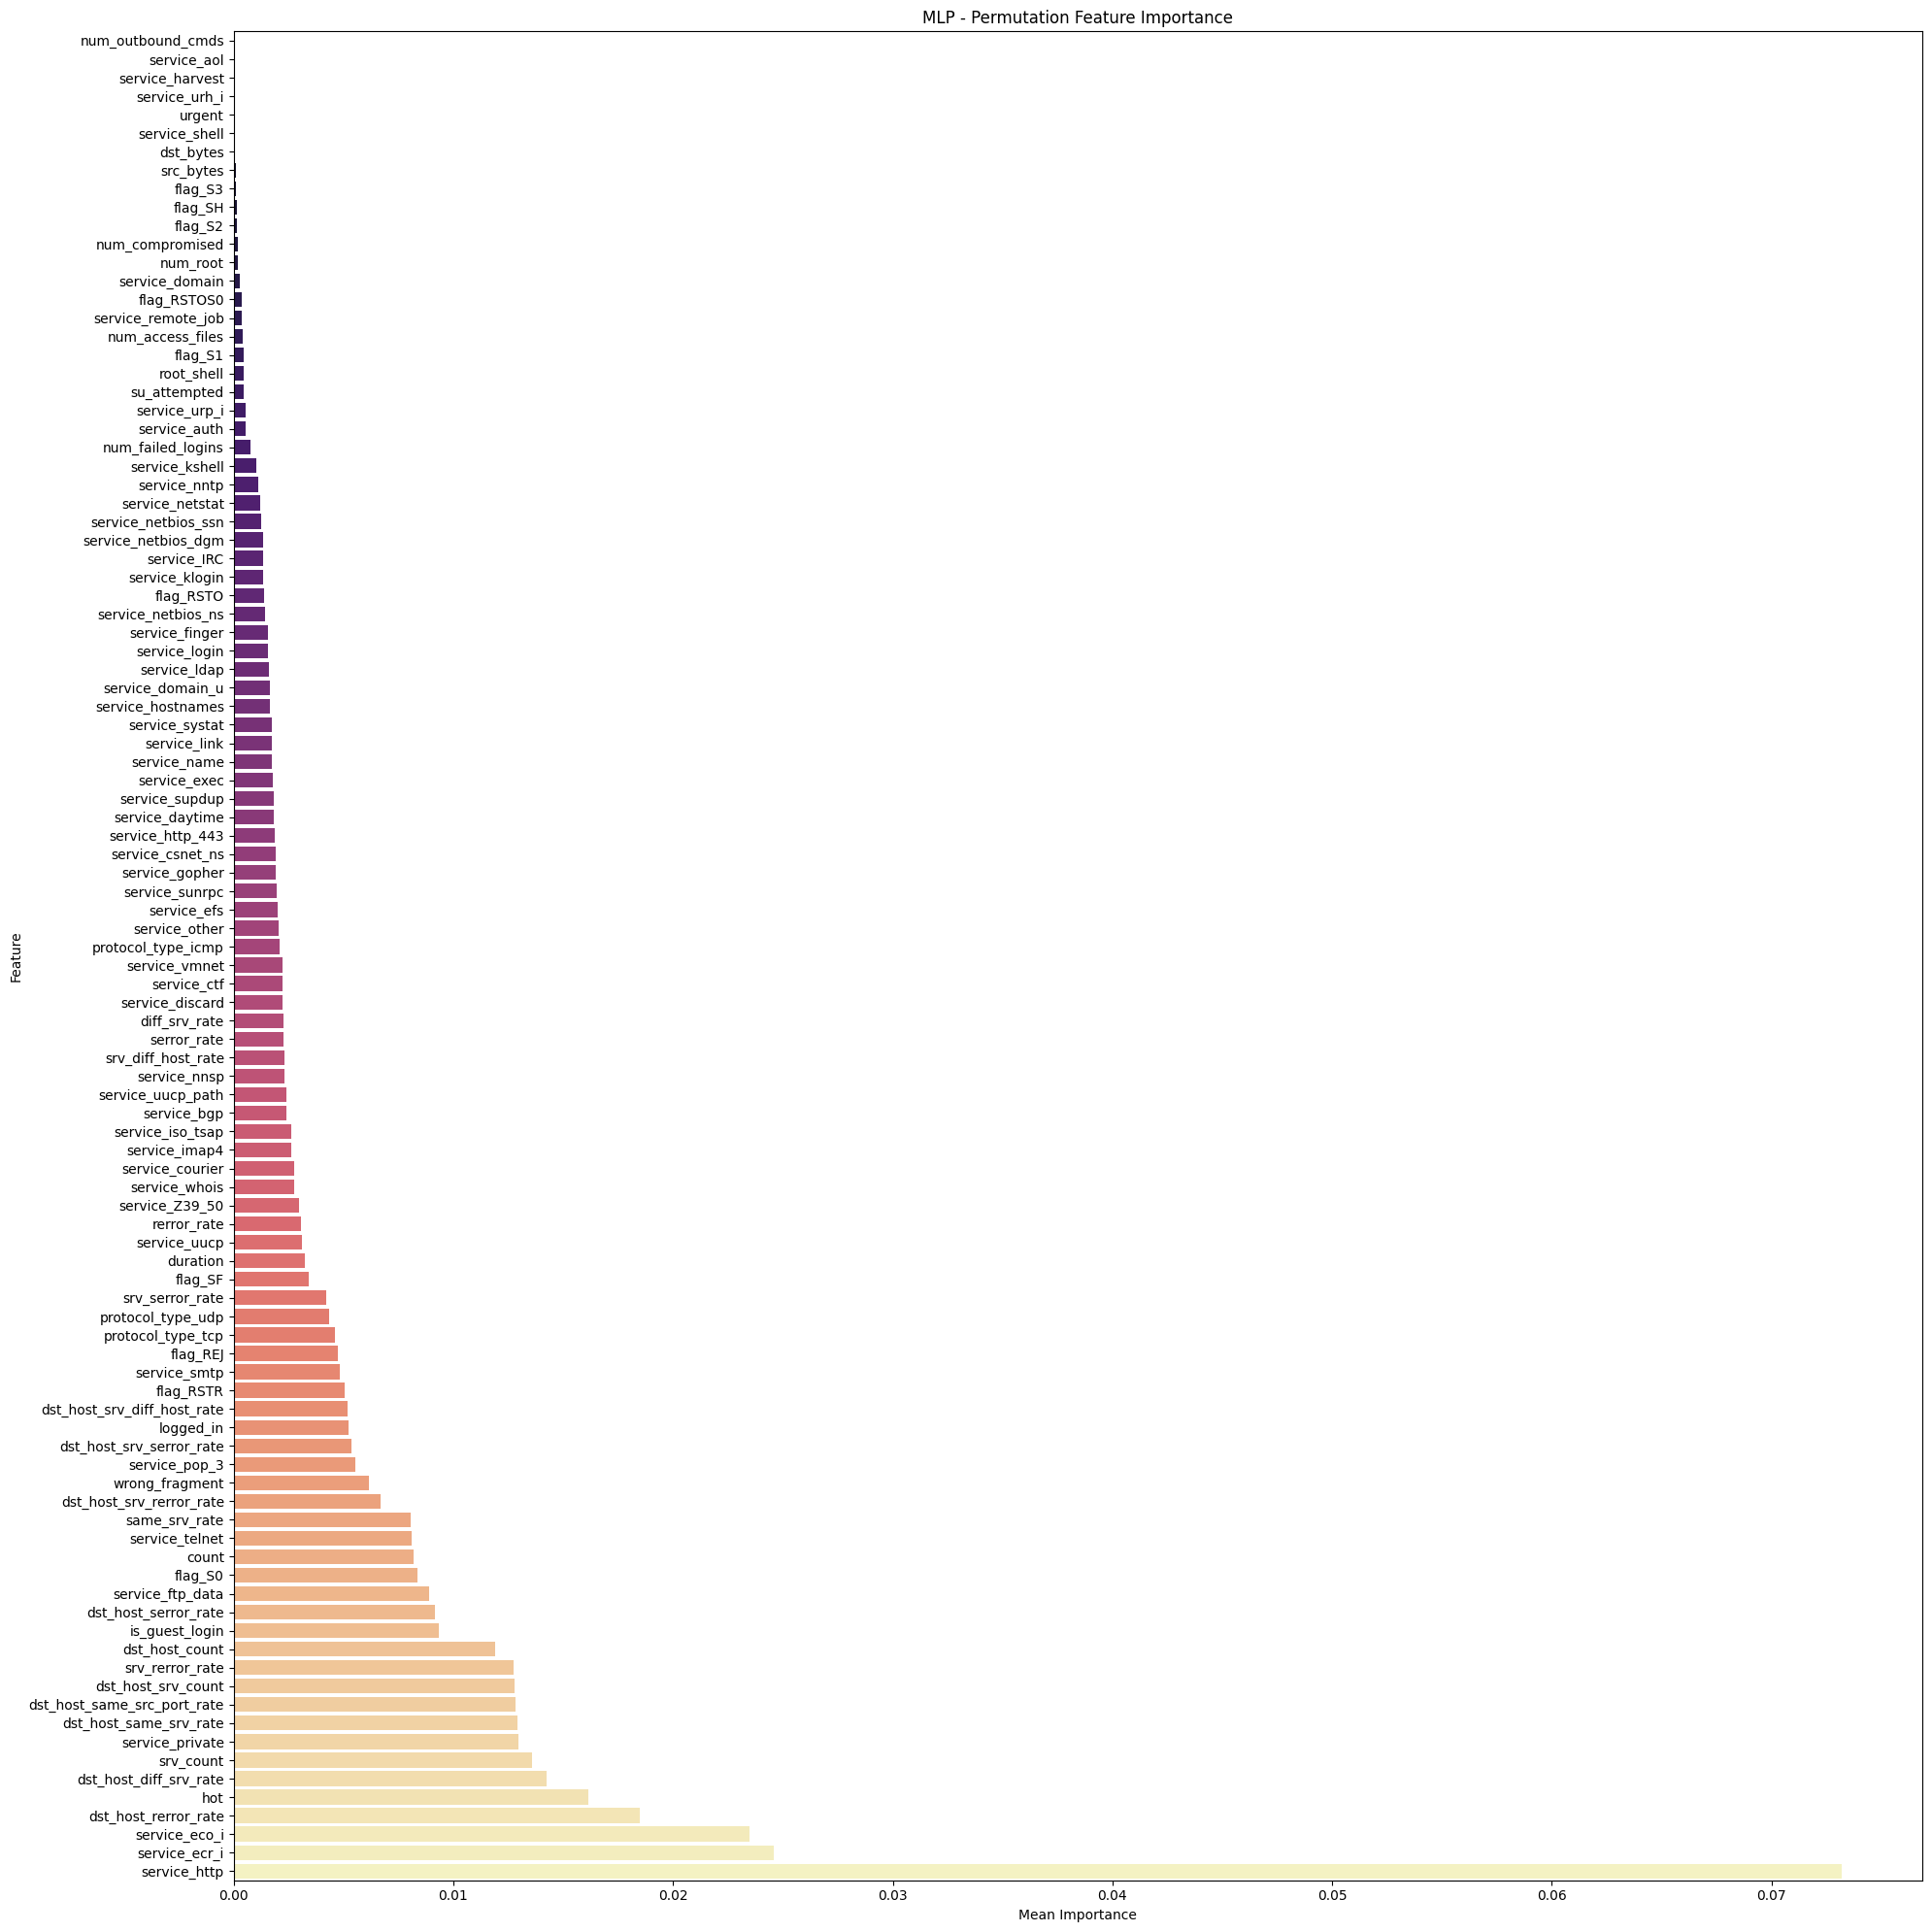

In [33]:

# Create a function to plot built-in feature importance for models that have it.
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        fi_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})
        fi_df = fi_df.sort_values("Importance", ascending=True)
        plt.figure(figsize=(20, 20))
        sns.barplot(x="Importance", y="Feature", data=fi_df, palette="viridis")
        plt.title(f"{model_name} - Built-in Feature Importance")
        plt.xlabel("Importance Score")
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not have built-in feature_importances_ attribute.")

# Function to plot permutation importance.
def plot_permutation_importance(model, model_name, X, y, feature_names):
    r = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_importance = r.importances_mean
    fi_df = pd.DataFrame({"Feature": feature_names, "Perm Importance": perm_importance})
    fi_df = fi_df.sort_values("Perm Importance", ascending=True)
    plt.figure(figsize=(20, 20))
    sns.barplot(x="Perm Importance", y="Feature", data=fi_df, palette="magma")
    plt.title(f"{model_name} - Permutation Feature Importance")
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()

# Get the feature names for the selected features.
selected_features = [final_feature_names[i] for i in selected_indices]

# Loop through each model to visualize feature importance.
for name, model in models.items():
    print(f"\nVisualizing feature importance for {name}:")
    if hasattr(model, "feature_importances_"):
        plot_feature_importance(model, name, selected_features)
    else:
        print(f"{name} does not have built-in feature importance. Computing permutation importance.")
        plot_permutation_importance(model, name, X_test_selected, y_test, selected_features)

# Also, compute permutation importance for the MLP model as an example.
print("\nPermutation importance for MLP:")
plot_permutation_importance(models["MLP"], "MLP", X_test_selected, y_test, selected_features)


In [35]:
models['Linear Regression'] = lr

Learning Curve for AdaBoost


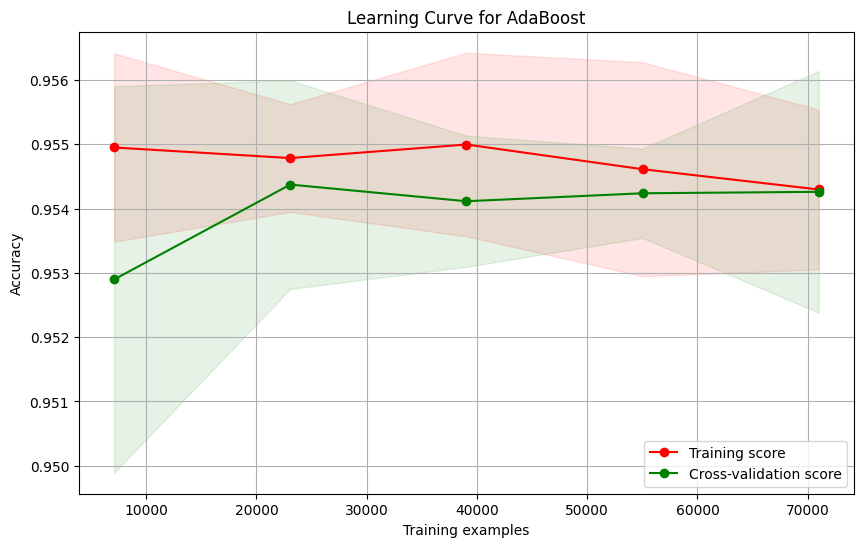

Learning Curve for Extra Trees


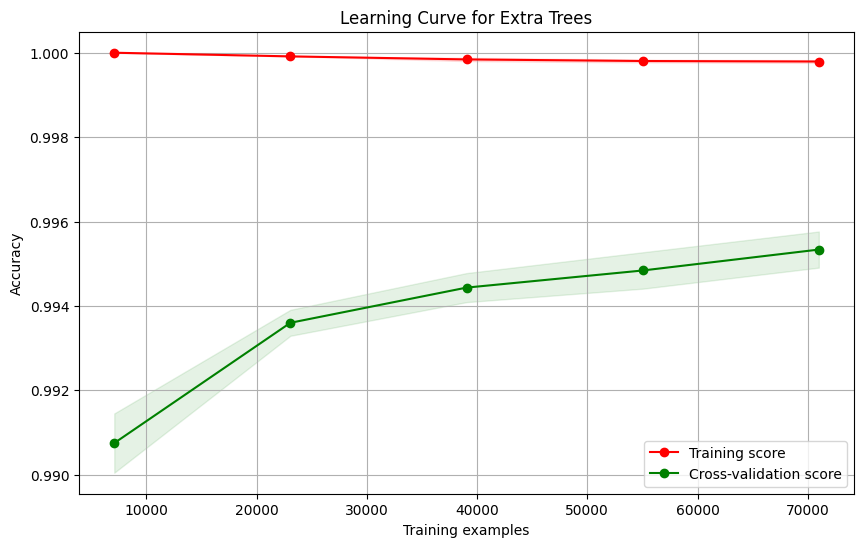

Learning Curve for Gradient Boost


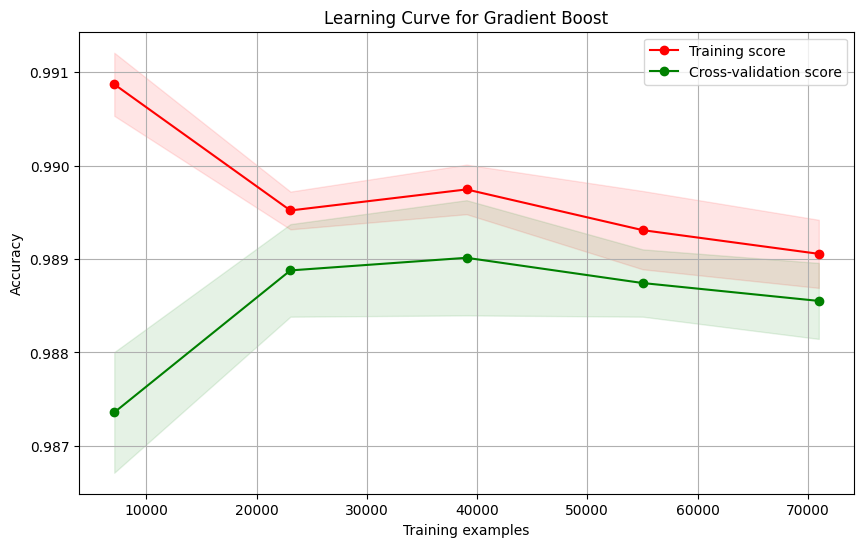

Learning Curve for Random Forest


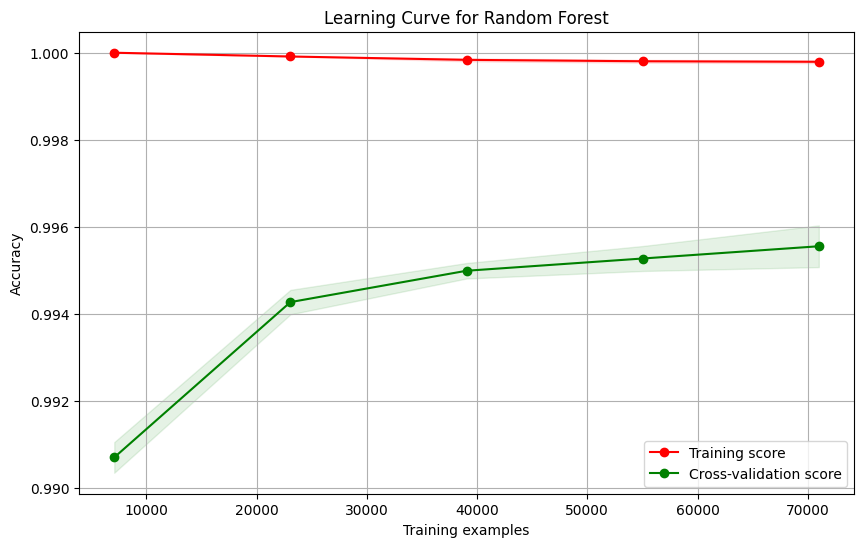

Learning Curve for MLP


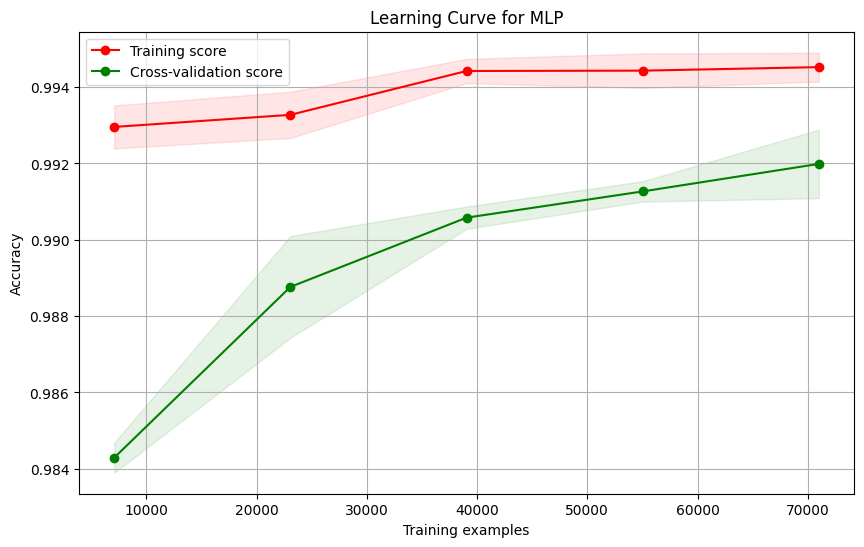

Learning Curve for Linear Regression


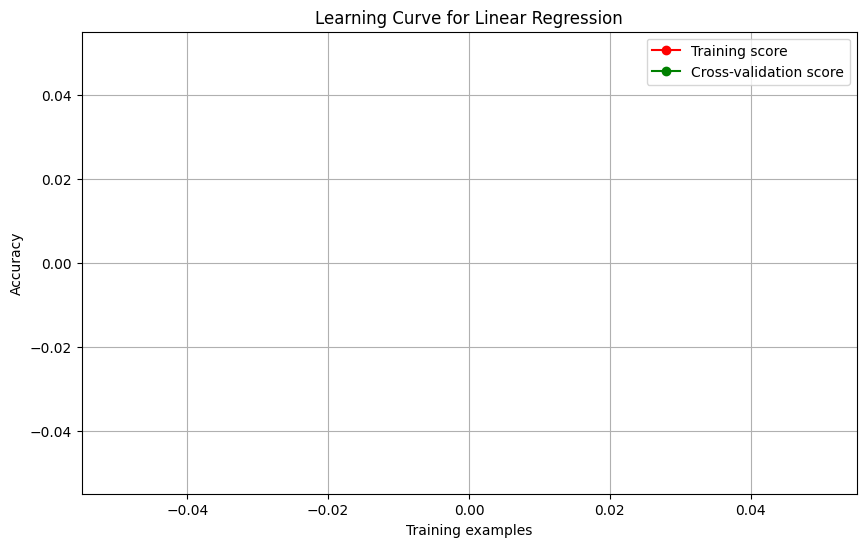

In [36]:

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    
    # Compute learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            n_jobs=n_jobs, train_sizes=train_sizes,
                                                            scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid(True)
    # Plot the standard deviation as a transparent range
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Loop through each model and plot its learning curve.
for name, model in models.items():
    title = f"Learning Curve for {name}"
    print(title)
    plot_learning_curve(model, title, X_train_selected, y_train, cv=5)


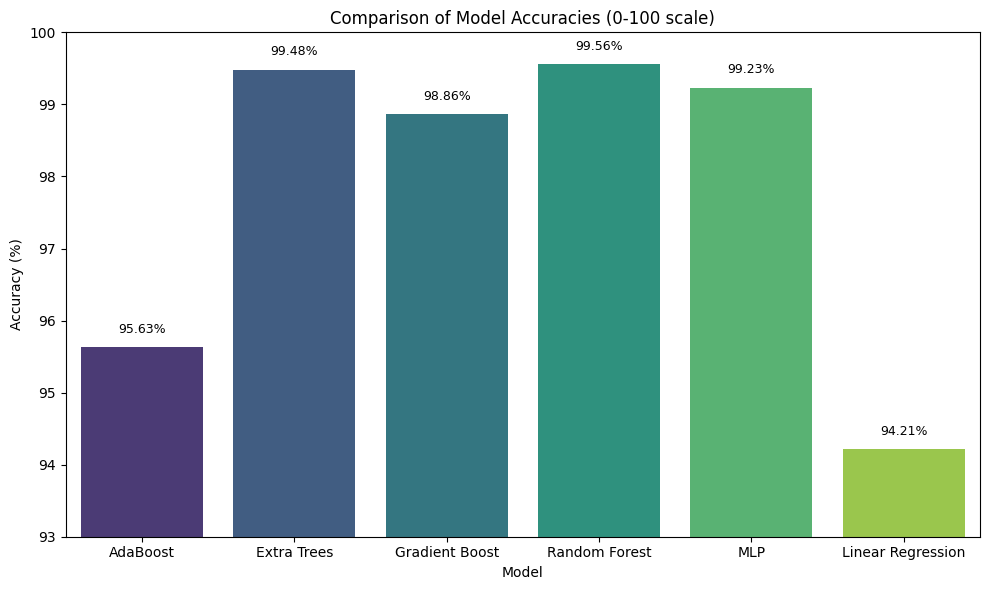

Model 'AdaBoost' saved as 'AdaBoost_model.pkl'
Model 'Extra Trees' saved as 'Extra_Trees_model.pkl'
Model 'Gradient Boost' saved as 'Gradient_Boost_model.pkl'
Model 'Random Forest' saved as 'Random_Forest_model.pkl'
Model 'MLP' saved as 'MLP_model.pkl'


In [ ]:
import pickle
import math

# Convert accuracy from 0-1 to 0-100
model_names = list(results.keys())
accuracy_values = [results[name] * 100 for name in model_names]

# Automatically determine lower bound of y-axis so that the lowest bar is visible
lowest_acc = min(accuracy_values)
# We'll go a bit below the lowest bar, but not below 0
y_lower_bound = max(0, math.floor(lowest_acc) - 1)

# Create a bar chart comparing model accuracies
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=model_names, y=accuracy_values, palette="viridis")

# Annotate each bar with its accuracy value
for i, bar in enumerate(bars.patches):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, bar_height + 0.2,
             f"{bar_height:.2f}%", ha='center', fontsize=9)

plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.title("Comparison of Model Accuracies (0-100 scale)")
# Ensure the y-axis includes all bars
plt.ylim(y_lower_bound, 100)
plt.tight_layout()
plt.show()

# Dump all models to disk
for name, model in models.items():
    filename = f"{name.replace(' ', '_')}_model.pkl"
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Model '{name}' saved as '{filename}'")